In [1]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    compress_repeated_epochs,
    batch_analysis,
)
from ad_ied.replay import replay_run
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import pickle
import seaborn as sns
import nelpy as nel
from matplotlib.ticker import AutoMinorLocator
from statannotations.Annotator import Annotator
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'D:\github\ad_ied\results'


## load replay results

In [2]:
save_path = r"D:\github\ad_ied\results\replay_v3"

df = replay_run.load_results(save_path, pre_task_post=True, verbose=False)
# df = df.query("decoding_median_error < 23 & score_pval_time_swap<0.05")

In [3]:
young = [
    r"X:\AD_sessions\AZ10\AZ10_210317_sess2",
    r"X:\AD_sessions\AZ10\AZ10_210322_sess4",
    r"X:\AD_sessions\AZ10\AZ10_210324_sess5",
    r"X:\AD_sessions\AZ10\AZ10_210329_sess6",
    r"X:\AD_sessions\AZ10\AZ10_210412_sess9",
    r"X:\AD_sessions\AZ10\AZ10_210419_sess11",
    r"X:\AD_sessions\AZ11\AZ11_210325_sess1",
    r"X:\AD_sessions\AZ11\AZ11_210422_sess7",
    r"X:\AD_sessions\AZ12\AZ12_210317_sess2",
    r"X:\AD_sessions\AZ12\AZ12_210323_sess3",
    r"X:\AD_sessions\AZ12\AZ12_210325_sess4",
    r"X:\AD_sessions\AZ12\AZ12_210330_sess5",
    r"X:\AD_sessions\AZ12\AZ12_210413_sess7",
    r"X:\AD_sessions\AZ18\AZ18_221119_sess4",
    r"X:\AD_sessions\AZ18\AZ18_221120_sess5",
    r"X:\AD_sessions\AZ18\AZ18_221121_sess6",
    r"X:\AD_sessions\AZ18\AZ18_221124_sess8",
    r"X:\AD_sessions\AZ18\AZ18_221129_sess10",
]
old = [
    r"X:\AD_sessions\AZ13\AZ13_220930_sess7",
    r"X:\AD_sessions\AZ13\AZ13_221003_sess8",
    r"X:\AD_sessions\AZ13\AZ13_221007_sess12",
    r"X:\AD_sessions\AZ16\AZ16_221101_sess4",
    r"X:\AD_sessions\AZ16\AZ16_221104_sess7",
    r"X:\AD_sessions\AZ16\AZ16_221109_sess10",
]
df["age_label"] = df.basepath.apply(
    lambda x: "old" if x in old else "young" if x in young else None
)
df["age_label"].value_counts()

young    20230
old       1214
Name: age_label, dtype: int64

## get pre and post ied labels

In [4]:
def get_mutually_exclusive_epochs(
    ied_epochs, pre_interval=[-20, -10], post_interval=[0, 10]
):
    ied_obs_pre_ = nel.EpochArray(
        np.array(
            [ied_epochs.start + pre_interval[0], ied_epochs.start + pre_interval[1]]
        ).T
    )
    ied_obs_post_ = nel.EpochArray(
        np.array(
            [ied_epochs.stop + post_interval[0], ied_epochs.stop + post_interval[1]]
        ).T
    )

    ied_obs_pre = ied_obs_pre_[~ied_obs_post_]
    ied_obs_post = ied_obs_post_[~ied_obs_pre_]

    return ied_obs_pre, ied_obs_post


def extract_pre_post_ied_replay(basepath, df):
    current_df = df.query("basepath==@basepath")

    ied_epochs = loading.load_ied_events(basepath)
    if len(ied_epochs) == 0:
        print(f"no IED file {basepath}")
        return pd.DataFrame()

    ied_obs_pre, ied_obs_post = get_mutually_exclusive_epochs(ied_epochs)
    current_df["label"] = "other"
    idx = functions.in_intervals(current_df.start.values, ied_obs_pre.data)
    current_df.loc[idx, "label"] = "pre"
    idx = functions.in_intervals(current_df.start.values, ied_obs_post.data)
    current_df.loc[idx, "label"] = "post"

    return current_df


results_df = pd.DataFrame()
for basepath in df.basepath.unique():
    current_df = extract_pre_post_ied_replay(basepath, df)
    results_df = pd.concat([results_df, current_df], ignore_index=True)

no IED file X:\AD_sessions\Naz1\Naz1_210811_sess26


In [5]:
query = "epoch.str.contains('tmaze|post') & decoding_median_error < 25"
print(results_df.query(query).label.value_counts())

query = "epoch.str.contains('tmaze|post') & decoding_median_error < 25 & score_pval_col_cycle < 0.05"
print(results_df.query(query).label.value_counts())


other    19901
pre       1084
post       866
Name: label, dtype: int64
other    2453
pre       137
post      111
Name: label, dtype: int64


## proportions of pre and post IED replays

In [6]:
prop_df = (
    results_df.query("epoch.str.contains('post') & decoding_median_error < 25")
    .groupby("basepath")
    .apply(
        lambda x: pd.Series(
            {
                "n_replays": len(x.query("score_pval_col_cycle < 0.05")),
                "n_canidates": len(x),
                "n_replays_pre_ied": len(
                    x.query("score_pval_col_cycle < 0.05 & label=='pre'")
                ),
                "n_canidates_pre_ied": len(x.query("label=='pre'")),
                "n_replays_post_ied": len(
                    x.query("score_pval_col_cycle < 0.05 & label=='post'")
                ),
                "n_canidates_post_ied": len(x.query("label=='post'")),
            }
        )
    )
    .reset_index()
)
# prop_df["prop_replay"] = prop_df.n_replays / prop_df.n_canidates
display(prop_df)
print(
    f"Overall proportion of replays compared to canidates: {prop_df.n_replays.sum() / prop_df.n_canidates.sum():.2f}"
)
print(
    f"Pre IED proportion of replays compared to canidates: {prop_df.n_replays_pre_ied.sum() / prop_df.n_canidates_pre_ied.sum():.2f}"
)
print(
    f"Post IED proportion of replays compared to canidates: {prop_df.n_replays_post_ied.sum() / prop_df.n_canidates_post_ied.sum():.2f}"
)
print("")
print(
    f"Post IED proportion of replays compared Pre IED replays: {prop_df.n_replays_post_ied.sum() / prop_df.n_replays_pre_ied.sum():.2f}"
)
print("")
print(
    f"Pre IED proportion of replays compared to n replays: {prop_df.n_replays_pre_ied.sum() / prop_df.n_replays.sum():.3f}"
)
print(
    f"Post IED proportion of replays compared to n replays: {prop_df.n_replays_post_ied.sum() / prop_df.n_replays.sum():.3f}"
)
print("")
stat, pval = proportions_ztest(
    prop_df[["n_replays_pre_ied", "n_replays_post_ied"]].sum(),
    prop_df[["n_canidates_pre_ied", "n_canidates_post_ied"]].sum(),
)
print(f"pre post ied prop test p-value = {pval:.3f}")

print("")
stat, pval = proportions_ztest(
    prop_df[["n_replays_pre_ied", "n_replays_post_ied"]].sum(),
    prop_df[["n_replays", "n_replays"]].sum(),
)
print(f"pre post ied / n replays prop test p-value = {pval:.5f} z stat = {stat:.5f}")

,basepath,n_replays,n_canidates,n_replays_pre_ied,n_canidates_pre_ied,n_replays_post_ied,n_canidates_post_ied
0,X:\AD_sessions\AZ11\AZ11_210422_sess7,5,53,0,0,0,0
1,X:\AD_sessions\AZ11\AZ11_210427_sess8,419,5372,3,51,1,40
2,X:\AD_sessions\AZ12\AZ12_210317_sess2,21,90,1,9,11,48
3,X:\AD_sessions\AZ12\AZ12_210323_sess3,1358,8474,88,573,62,381
4,X:\AD_sessions\AZ12\AZ12_210325_sess4,424,4375,40,394,29,345
5,X:\AD_sessions\AZ12\AZ12_210330_sess5,13,154,1,11,0,6
6,X:\AD_sessions\AZ13\AZ13_220930_sess7,21,153,1,6,4,5
7,X:\AD_sessions\AZ13\AZ13_221003_sess8,28,130,0,8,1,2
8,X:\AD_sessions\AZ13\AZ13_221007_sess12,24,162,0,0,0,2
9,X:\AD_sessions\AZ18\AZ18_221119_sess4,7,62,0,0,0,0


Overall proportion of replays compared to canidates: 0.12
Pre IED proportion of replays compared to canidates: 0.13
Post IED proportion of replays compared to canidates: 0.13

Post IED proportion of replays compared Pre IED replays: 0.82

Pre IED proportion of replays compared to n replays: 0.053
Post IED proportion of replays compared to n replays: 0.043

pre post ied prop test p-value = 0.864

pre post ied / n replays prop test p-value = 0.10307 z stat = 1.63014


In [7]:
prop_df = pd.read_csv(r"D:\github\ad_ied\results\replay_ied.csv")
prop_df

,Unnamed: 0,basepath,n_replays,n_canidates,n_replays_pre_ied,n_canidates_pre_ied,n_replays_post_ied,n_canidates_post_ied
0,0,X:\AD_sessions\AZ11\AZ11_210422_sess7,5,53,0,3,0,1
1,1,X:\AD_sessions\AZ11\AZ11_210427_sess8,419,5372,9,102,8,81
2,2,X:\AD_sessions\AZ12\AZ12_210317_sess2,21,90,2,18,2,6
3,3,X:\AD_sessions\AZ12\AZ12_210323_sess3,1358,8474,178,1145,110,761
4,4,X:\AD_sessions\AZ12\AZ12_210325_sess4,424,4375,76,785,54,688
5,5,X:\AD_sessions\AZ12\AZ12_210330_sess5,13,154,2,22,0,12
6,6,X:\AD_sessions\AZ13\AZ13_220930_sess7,21,153,1,12,4,10
7,7,X:\AD_sessions\AZ13\AZ13_221003_sess8,28,130,2,16,2,4
8,8,X:\AD_sessions\AZ13\AZ13_221007_sess12,24,162,0,0,0,4
9,9,X:\AD_sessions\AZ18\AZ18_221119_sess4,7,62,0,0,0,0


In [8]:
import statsmodels.api as sm

df_prop_pre = pd.DataFrame()
df_prop_pre["prop"] = prop_df.n_replays_pre_ied / prop_df.n_replays
df_prop_pre["n_replays"] = prop_df.n_replays
df_prop_pre["label"] = "Pre"
df_prop_pre["basepath"] = prop_df.basepath

df_prop_post = pd.DataFrame()
df_prop_post["prop"] = prop_df.n_replays_post_ied / prop_df.n_replays
df_prop_post["n_replays"] = prop_df.n_replays
df_prop_post["label"] = "Post"
df_prop_post["basepath"] = prop_df.basepath

df_prop = pd.concat([df_prop_pre, df_prop_post], ignore_index=True)
df_prop = sm.add_constant(df_prop)
df_prop["label_binary"] = (df_prop["label"] == "Pre") * 1

df_prop.to_csv(r"D:\github\ad_ied\results\replay_ied_df_prop.csv", index=False)

logit_model = sm.GLM(
    df_prop.prop,
    df_prop[["const", "label_binary"]],
    freq_weights=df_prop.n_replays,
    family=sm.families.Binomial(),
)
result = logit_model.fit()

print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   prop   No. Observations:                   24
Model:                            GLM   Df Residuals:                     5166
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1147.6
Date:                Wed, 03 May 2023   Deviance:                       176.21
Time:                        15:16:30   Pearson chi2:                     145.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5287
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -2.5451      0.076    -33.603   

In [9]:
result.pvalues.label_binary

2.506216785186769e-05

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Pre vs. Post: Custom statistical test, P_val:2.506e-05


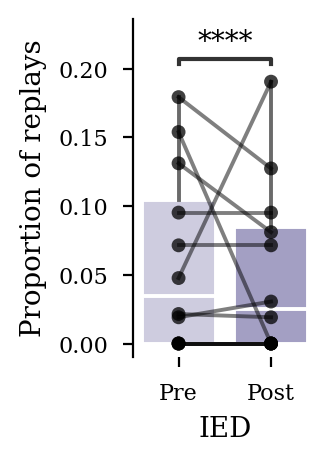

In [39]:
fig, ax = plt.subplots(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

group_colors = {"Pre": "#ccc9e2", "Post": "#9e99c9"}
sns.set_palette(sns.color_palette(group_colors.values()))


# def reindex_df(df, weight_col):
#     """expand the dataframe to prepare for resampling
#     result is 1 row per count per sample"""
#     df = df.reindex(df.index.repeat(df[weight_col]))
#     df.reset_index(drop=True, inplace=True)
#     return df


# temp_df = reindex_df(df_prop, weight_col="n_replays")
# sns.boxplot(data=df_prop,x="label",y="prop")
sns.boxplot(
    data=df_prop,
    x="label",
    y="prop",
    showfliers=False,
    medianprops=dict(color="white", alpha=1),
    capprops=dict(alpha=0),
    boxprops=dict(edgecolor="white"),
)
sns.lineplot(
    y="prop",
    x="label",
    data=df_prop,
    units="basepath",
    estimator=None,
    color="k",
    alpha=.5,
    legend=True,
    zorder = 1000,
)
sns.stripplot(data=df_prop, x="label", y="prop", color="k",jitter=False,alpha=.75)

box_pairs = [("Pre", "Post")]
annotator = Annotator(
    ax,
    box_pairs,
    data=df_prop,
    x="label",
    y="prop",
)
(annotator
    .configure(test=None, test_short_name="glm")
    .set_pvalues(pvalues=[result.pvalues.label_binary])
    .annotate())


ax.set_ylabel("Proportion of replays")
ax.set_xlabel("IED")
# ax.legend("")
sns.despine(bottom=True)

plt.savefig(
    os.path.join(fig_save_path, "pre_post_ied_replay_prop_sess_by_sess_paired.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [10]:
pval


0.10307096135782055

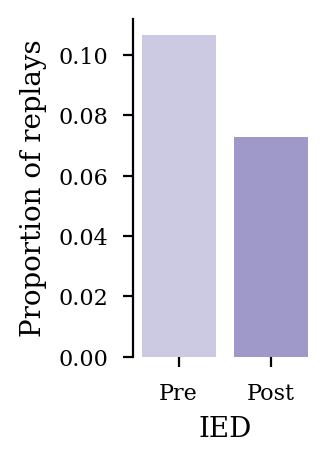

In [11]:
labels = ["Pre", "Post"]
prop = [
    prop_df.n_replays_pre_ied.sum() / prop_df.n_replays.sum(),
    prop_df.n_replays_post_ied.sum() / prop_df.n_replays.sum(),
]


fig, ax = plt.subplots(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

group_colors = {"Pre": "#ccc9e2", "Post": "#9e99c9"}

# colors = ["#7b3294", "slategrey", "#008837"]
# Horizontal Bar Plot
ax.bar(labels, prop, color=group_colors.values())

# Remove axes splines
for s in ["top", "right"]:
    ax.spines[s].set_visible(False)

ax.set_ylabel("Proportion of replays")
ax.set_xlabel("IED")

sns.despine(bottom=True)
# plt.savefig(
#     os.path.join(fig_save_path, "pre_post_ied_replay_prop.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

In [12]:
results_df.query("age_label=='old' & decoding_median_error < 25").basepath.unique()


array(['X:\\AD_sessions\\AZ13\\AZ13_220930_sess7',
       'X:\\AD_sessions\\AZ13\\AZ13_221003_sess8',
       'X:\\AD_sessions\\AZ13\\AZ13_221007_sess12'], dtype=object)

### plotting helper

In [13]:
def annotate_this(df, x, y, ax=None, hue=None):
    if ax is None:
        ax = plt.gca()
    box_pairs = [("pre", "post"), ("other", "pre"), ("other", "post")]
    annotator = Annotator(
        ax,
        box_pairs,
        data=df,
        x=x,
        y=y,
    )
    annotator.configure(
        test="Mann-Whitney",
        text_format="star",
        loc="outside",
        comparisons_correction=None,
        verbose=0,
    )
    annotator.apply_and_annotate()

In [14]:
for basepath in results_df.basepath.unique():
    pre_sleep_mean = results_df.query(
        "basepath == @basepath & epoch=='pre_sleep' & score_pval_col_cycle < 0.05"
    ).trajectory_score.mean()
    results_df.loc[results_df.basepath == basepath, "traj_score_presleep_norm"] = (
        results_df.query("basepath == @basepath").trajectory_score / pre_sleep_mean
    )

    # normalize to pre IED canidates
    pre_ied_mean = results_df.query(
        "basepath == @basepath & epoch=='post_sleep' & label=='pre' & score_pval_col_cycle < 0.05"
    ).trajectory_score.median()
    results_df.loc[results_df.basepath == basepath, "traj_score_pre_post_ied_norm"] = (
        results_df.query("basepath == @basepath").trajectory_score / pre_ied_mean
    )

# for basepath in results_df.basepath.unique():
#     pre_sleep_mean = results_df.query("basepath == @basepath & epoch=='pre_sleep'").trajectory_score.mean()
#     results_df.loc[results_df.basepath == basepath,"traj_score_presleep_norm"] = results_df.query("basepath == @basepath").trajectory_score / pre_sleep_mean

### young and old trajectory score

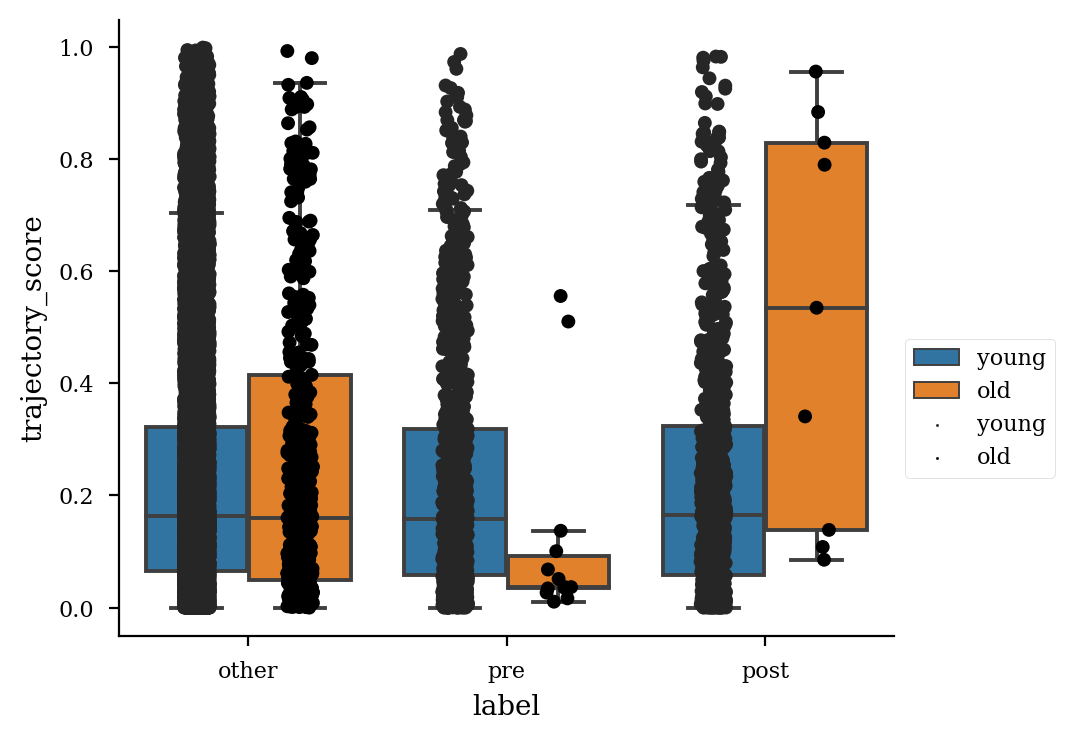

In [15]:
query = "decoding_median_error < 25 & epoch.str.contains('post')"

plt.figure(figsize=(5, 4))
sns.boxplot(
    data=results_df.query(query),
    x="label",
    y="trajectory_score",
    hue="age_label",
    showfliers=False,
)
sns.stripplot(
    data=results_df.query(query),
    x="label",
    y="trajectory_score",
    hue="age_label",
    color="k",
    dodge=True,
)
# annotate_this(results_df.query(query),"label","trajectory_score",ax=plt.gca(),hue="age_label")
plt.gca().legend(bbox_to_anchor=(1, 0.5), markerscale=0.1)
sns.despine()

In [16]:
results_df.keys()


Index(['start', 'stop', 'duration', 'n_active', 'inactive_bin_prop',
       'trajectory_score', 'r_squared', 'slope', 'intercept',
       'score_pval_time_swap', 'score_pval_col_cycle', 'score_z_time_swap',
       'score_z_col_cycle', 'traj_dist', 'traj_speed', 'traj_step',
       'replay_type', 'pop_partic', 'decoding_r2', 'decoding_r2_pval',
       'decoding_median_error', 'total_units', 'direction', 'epoch',
       'basepath', 'age_label', 'label', 'traj_score_presleep_norm',
       'traj_score_pre_post_ied_norm'],
      dtype='object')

In [17]:
results_df.query(
    "decoding_median_error < 25 & epoch.str.contains('post') & label == 'post' & age_label=='old' & score_pval_col_cycle < 0.05"
)
results_df.query(
    "decoding_median_error < 25 & epoch.str.contains('post') & label == 'post' & age_label=='old'"
)
results_df.query(
    "decoding_median_error < 25 & epoch.str.contains('post') & label == 'pre' & age_label=='old'"
)

,start,stop,duration,n_active,inactive_bin_prop,trajectory_score,r_squared,slope,intercept,score_pval_time_swap,...,decoding_r2_pval,decoding_median_error,total_units,direction,epoch,basepath,age_label,label,traj_score_presleep_norm,traj_score_pre_post_ied_norm
30769,13508.3865,13508.4665,0.08,11,0.000000,0.137038,0.073988,-4.822222,656.123611,0.639361,...,0.003984,12.638749,42.0,right_epochs,post_sleep,X:\AD_sessions\AZ13\AZ13_220930_sess7,old,pre,0.249508,0.246577
30777,14289.8865,14289.9465,0.06,9,0.000000,0.034378,0.000000,0.000000,97.449074,1.000000,...,0.003984,12.638749,42.0,right_epochs,post_sleep,X:\AD_sessions\AZ13\AZ13_220930_sess7,old,pre,0.062592,0.061857
30778,14305.9665,14306.0465,0.08,19,0.000000,0.555761,0.088889,-1.205556,317.965278,0.504496,...,0.003984,12.638749,42.0,right_epochs,post_sleep,X:\AD_sessions\AZ13\AZ13_220930_sess7,old,pre,1.011887,1.000000
30783,14461.8065,14461.8665,0.06,10,0.000000,0.100647,0.750000,-57.263889,9319.949074,0.000999,...,0.003984,12.638749,42.0,right_epochs,post_sleep,X:\AD_sessions\AZ13\AZ13_220930_sess7,old,pre,0.183250,0.181097
30791,15256.8065,15256.8865,0.08,9,0.000000,0.036583,0.121255,19.288889,-3528.962500,1.000000,...,0.003984,12.638749,42.0,right_epochs,post_sleep,X:\AD_sessions\AZ13\AZ13_220930_sess7,old,pre,0.066607,0.065825
30834,18105.7265,18105.8065,0.08,13,0.000000,0.051170,0.062392,18.083333,-5902.701389,0.650350,...,0.003984,12.638749,42.0,right_epochs,post_sleep,X:\AD_sessions\AZ13\AZ13_220930_sess7,old,pre,0.093166,0.092072
31095,14456.8583,14456.9183,0.06,10,0.000000,0.036235,0.636935,39.366197,-8113.474178,0.682318,...,0.003984,6.983666,48.0,left_epochs,post_sleep,X:\AD_sessions\AZ13\AZ13_221003_sess8,old,pre,0.043673,NaN
31096,14460.4783,14460.5583,0.08,12,0.000000,0.034248,0.003638,4.542254,-858.485915,0.606394,...,0.003984,6.983666,48.0,left_epochs,post_sleep,X:\AD_sessions\AZ13\AZ13_221003_sess8,old,pre,0.041278,NaN
31097,14463.7983,14463.8783,0.08,17,0.000000,0.010575,0.000273,-0.908451,282.830986,1.000000,...,0.003984,6.983666,48.0,left_epochs,post_sleep,X:\AD_sessions\AZ13\AZ13_221003_sess8,old,pre,0.012746,NaN
31103,14574.6783,14574.7383,0.06,11,0.333333,0.510249,1.000000,-43.908451,10439.612676,0.845155,...,0.003984,6.983666,48.0,left_epochs,post_sleep,X:\AD_sessions\AZ13\AZ13_221003_sess8,old,pre,0.614990,NaN


### young and old trajectory score pre sleep norm

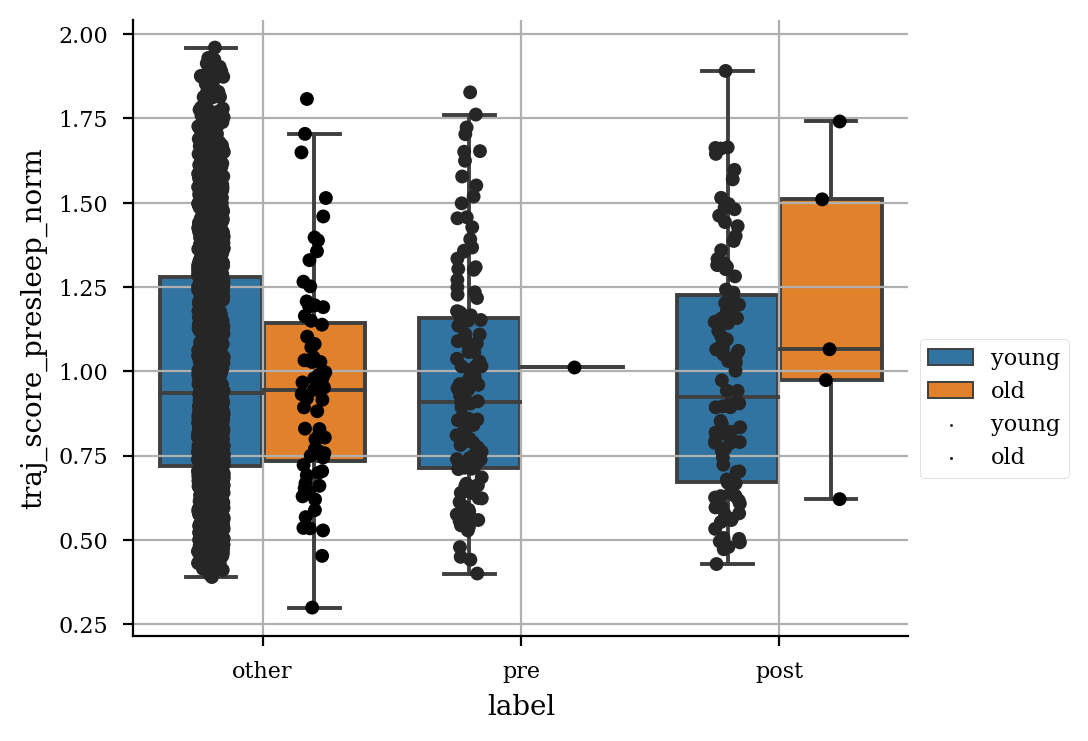

In [18]:
query = "decoding_median_error < 25 & epoch.str.contains('post') & score_pval_col_cycle < 0.05"

plt.figure(figsize=(5, 4))
sns.boxplot(
    data=results_df.query(query),
    x="label",
    y="traj_score_presleep_norm",
    hue="age_label",
    showfliers=False,
)
sns.stripplot(
    data=results_df.query(query),
    x="label",
    y="traj_score_presleep_norm",
    hue="age_label",
    color="k",
    dodge=True,
)
# annotate_this(results_df.query(query),"label","trajectory_score",ax=plt.gca(),hue="age_label")
plt.gca().legend(bbox_to_anchor=(1, 0.5), markerscale=0.1)
sns.despine()
plt.grid()

### trajectory score pre post IED and other

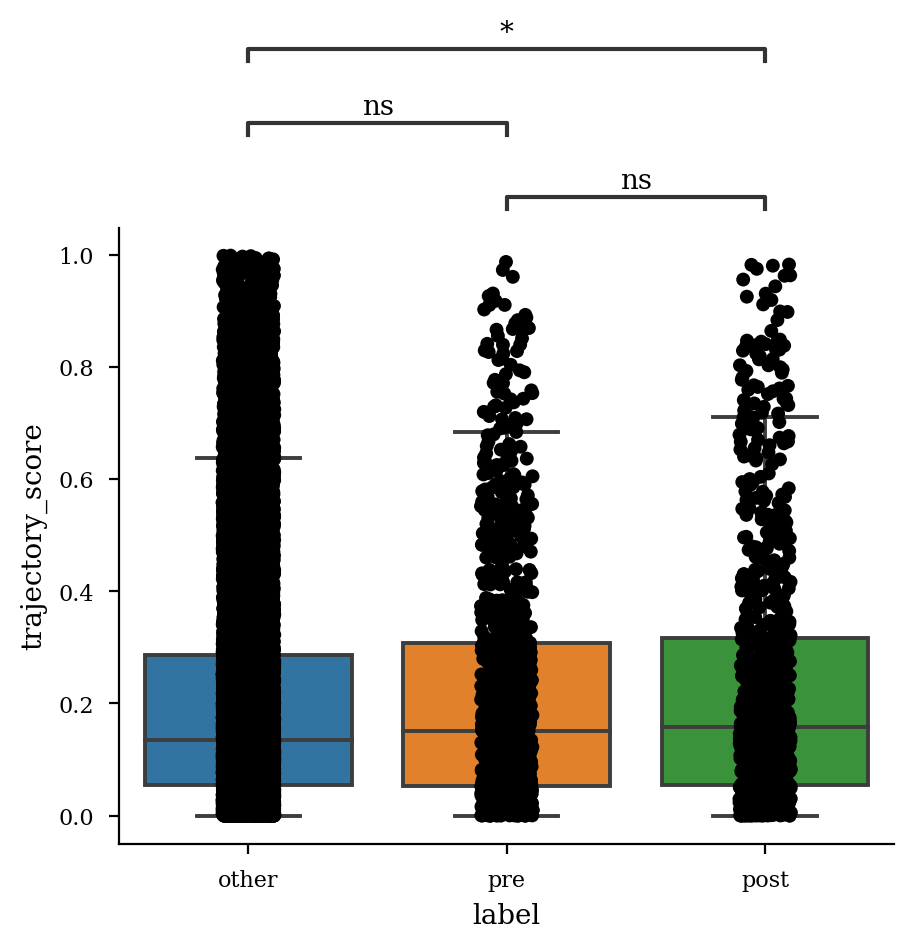

In [19]:
# query = "epoch.str.contains('tmaze|post') & decoding_median_error < 23 & score_pval_col_cycle < 0.05 & score_pval_time_swap<0.05"
query = "decoding_median_error < 25 & epoch.str.contains('post')"

plt.figure(figsize=(5, 4))
sns.boxplot(
    data=results_df.query(query), x="label", y="trajectory_score", showfliers=False
)
sns.stripplot(data=results_df.query(query), x="label", y="trajectory_score", color="k")
# plt.yscale("log")
annotate_this(results_df.query(query), "label", "trajectory_score", plt.gca())
sns.despine()

# plt.savefig(r"D:\github\ad_ied\results\relay_trajectory_score.pdf",dpi=300,bbox_inches="tight")
# plt.savefig(r"D:\github\ad_ied\results\relay_trajectory_score.svg",dpi=300,bbox_inches="tight")

In [496]:
group_colors.values()


dict_values(['#ccc9e2', '#9e99c9'])

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: Mann-Whitney-Wilcoxon test two-sided, P_val:1.488e-01 U_stat=6.741e+03


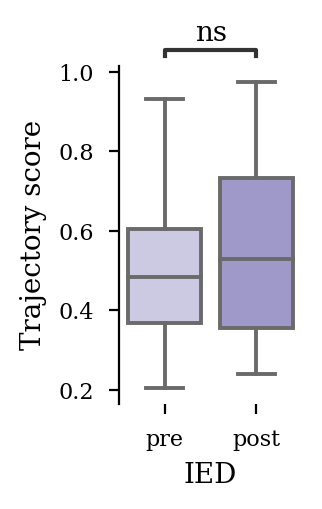

In [20]:
fig, ax = plt.subplots(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

group_colors = {"pre": "#ccc9e2", "post": "#9e99c9"}

query = "decoding_median_error < 25 & epoch.str.contains('post') & score_pval_col_cycle < 0.05"

sns.boxplot(
    data=results_df.query(query),
    x="label",
    y="trajectory_score",
    order=group_colors.keys(),
    palette=group_colors.values(),
    showfliers=False,
    saturation=1,
)
box_pairs = [
    ("pre", "post"),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results_df.query(query),
    x="label",
    y="trajectory_score",
    order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

ax.set_ylabel("Trajectory score")
ax.set_xlabel("IED")

sns.despine(bottom=True)
# plt.savefig(
#     os.path.join(fig_save_path, "trajectory_score.svg"), dpi=300, bbox_inches="tight"
# )

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: Mann-Whitney-Wilcoxon test two-sided, P_val:3.789e-01 U_stat=7.056e+03


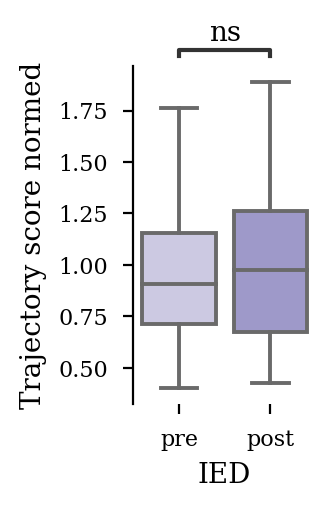

In [21]:
fig, ax = plt.subplots(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

group_colors = {"pre": "#ccc9e2", "post": "#9e99c9"}

query = "decoding_median_error < 25 & epoch.str.contains('post') & score_pval_col_cycle < 0.05"

sns.boxplot(
    data=results_df.query(query),
    x="label",
    y="traj_score_presleep_norm",
    order=group_colors.keys(),
    palette=group_colors.values(),
    showfliers=False,
    saturation=1,
)
box_pairs = [
    ("pre", "post"),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results_df.query(query),
    x="label",
    y="traj_score_presleep_norm",
    order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

ax.set_ylabel("Trajectory score normed")
ax.set_xlabel("IED")

sns.despine(bottom=True)
# plt.savefig(
#     os.path.join(fig_save_path, "traj_score_presleep_norm.svg"),
#     dpi=300,
#     bbox_inches="tight",
# )

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

pre vs. post: Mann-Whitney-Wilcoxon test two-sided, P_val:1.319e-01 U_stat=8.390e+03


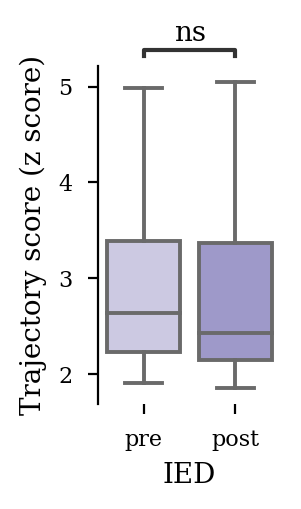

In [22]:
fig, ax = plt.subplots(
    figsize=functions.set_size("thesis", fraction=0.2, subplots=(3, 1)), edgecolor=None
)

group_colors = {"pre": "#ccc9e2", "post": "#9e99c9"}

query = "decoding_median_error < 25 & epoch.str.contains('post') & score_pval_col_cycle < 0.05"

sns.boxplot(
    data=results_df.query(query),
    x="label",
    y="score_z_col_cycle",
    order=group_colors.keys(),
    palette=group_colors.values(),
    showfliers=False,
    saturation=1,
)
box_pairs = [
    ("pre", "post"),
]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=results_df.query(query),
    x="label",
    y="score_z_col_cycle",
    order=group_colors.keys(),
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

ax.set_ylabel("Trajectory score (z score)")
ax.set_xlabel("IED")

sns.despine(bottom=True)
# plt.savefig(
#     os.path.join(fig_save_path, "score_z_col_cycle.svg"), dpi=300, bbox_inches="tight"
# )

### trajectory score normed to pre sleep

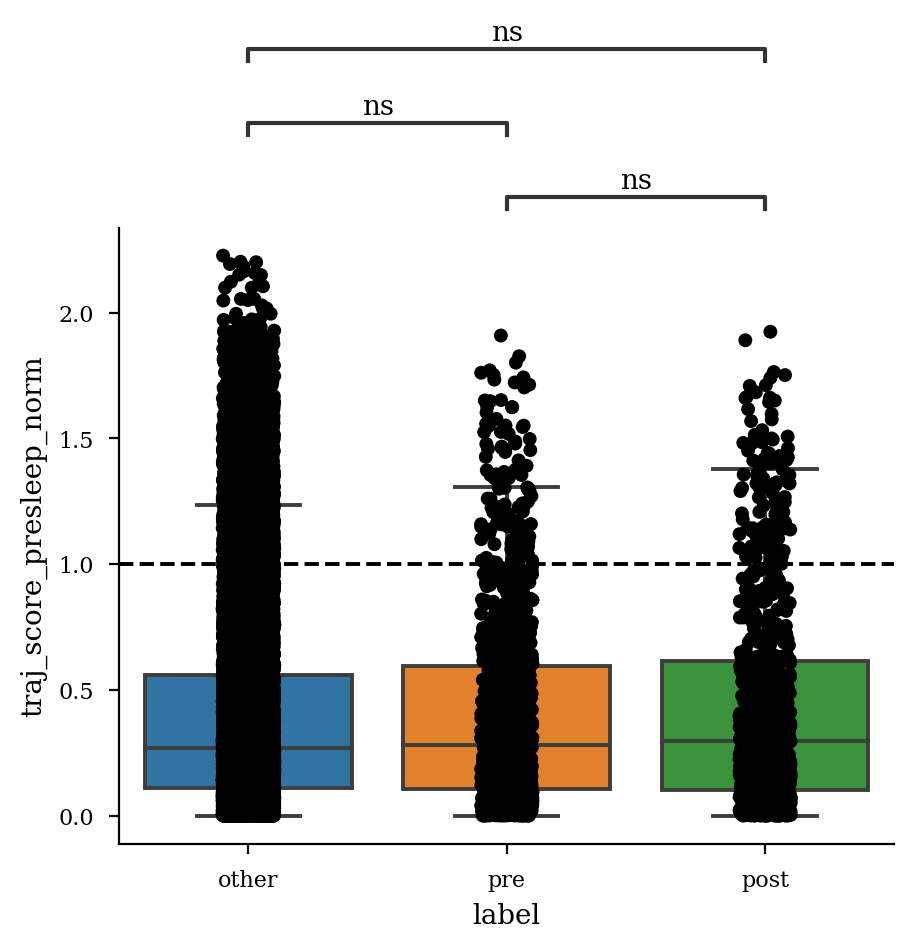

In [23]:
query = "decoding_median_error < 25 & epoch.str.contains('post')"

plt.figure(figsize=(5, 4))
sns.boxplot(
    data=results_df.query(query),
    x="label",
    y="traj_score_presleep_norm",
    showfliers=False,
)
sns.stripplot(
    data=results_df.query(query), x="label", y="traj_score_presleep_norm", color="k"
)
# plt.yscale("log")
annotate_this(results_df.query(query), "label", "traj_score_presleep_norm", plt.gca())
plt.axhline(1, color="k", linestyle="--")
sns.despine()

### trajectory score normed to pre IED scores

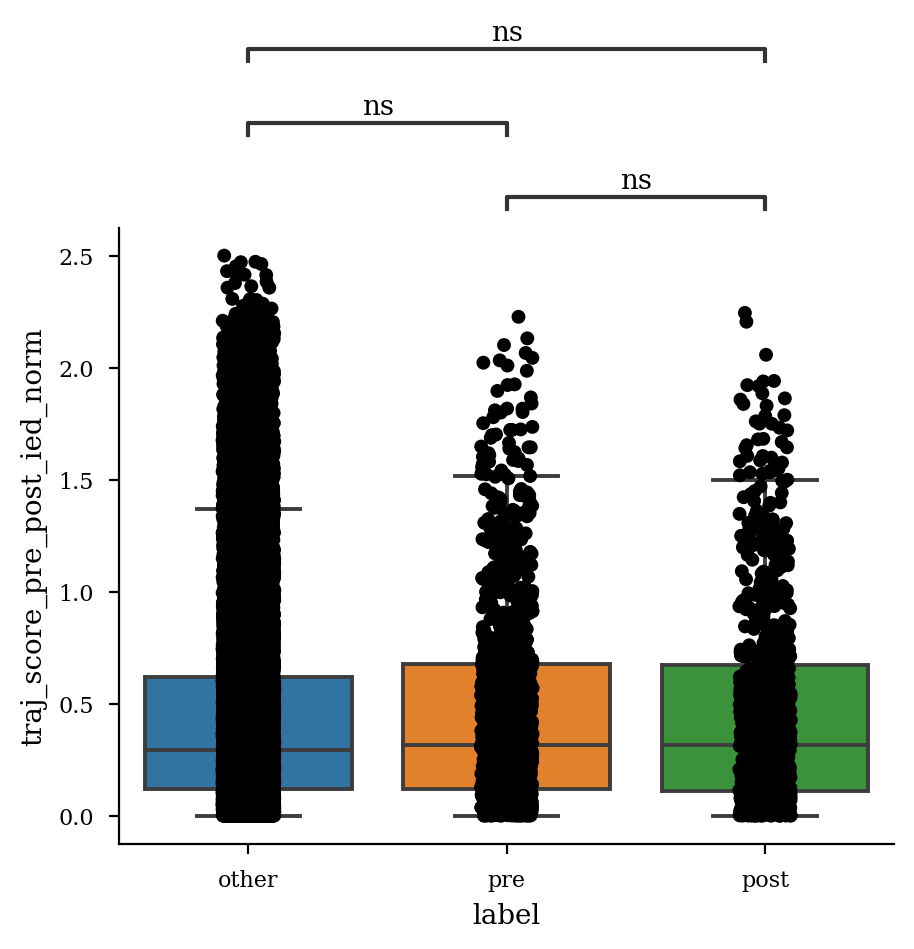

In [24]:
query = "decoding_median_error < 25 & epoch.str.contains('post')"
# query = "epoch.str.contains('post') & decoding_median_error < 25 & score_pval_time_swap<0.05"

plt.figure(figsize=(5, 4))
sns.boxplot(
    data=results_df.query(query),
    x="label",
    y="traj_score_pre_post_ied_norm",
    showfliers=False,
)
sns.stripplot(
    data=results_df.query(query), x="label", y="traj_score_pre_post_ied_norm", color="k"
)
# plt.yscale("log")
annotate_this(
    results_df.query(query), "label", "traj_score_pre_post_ied_norm", plt.gca()
)
sns.despine()

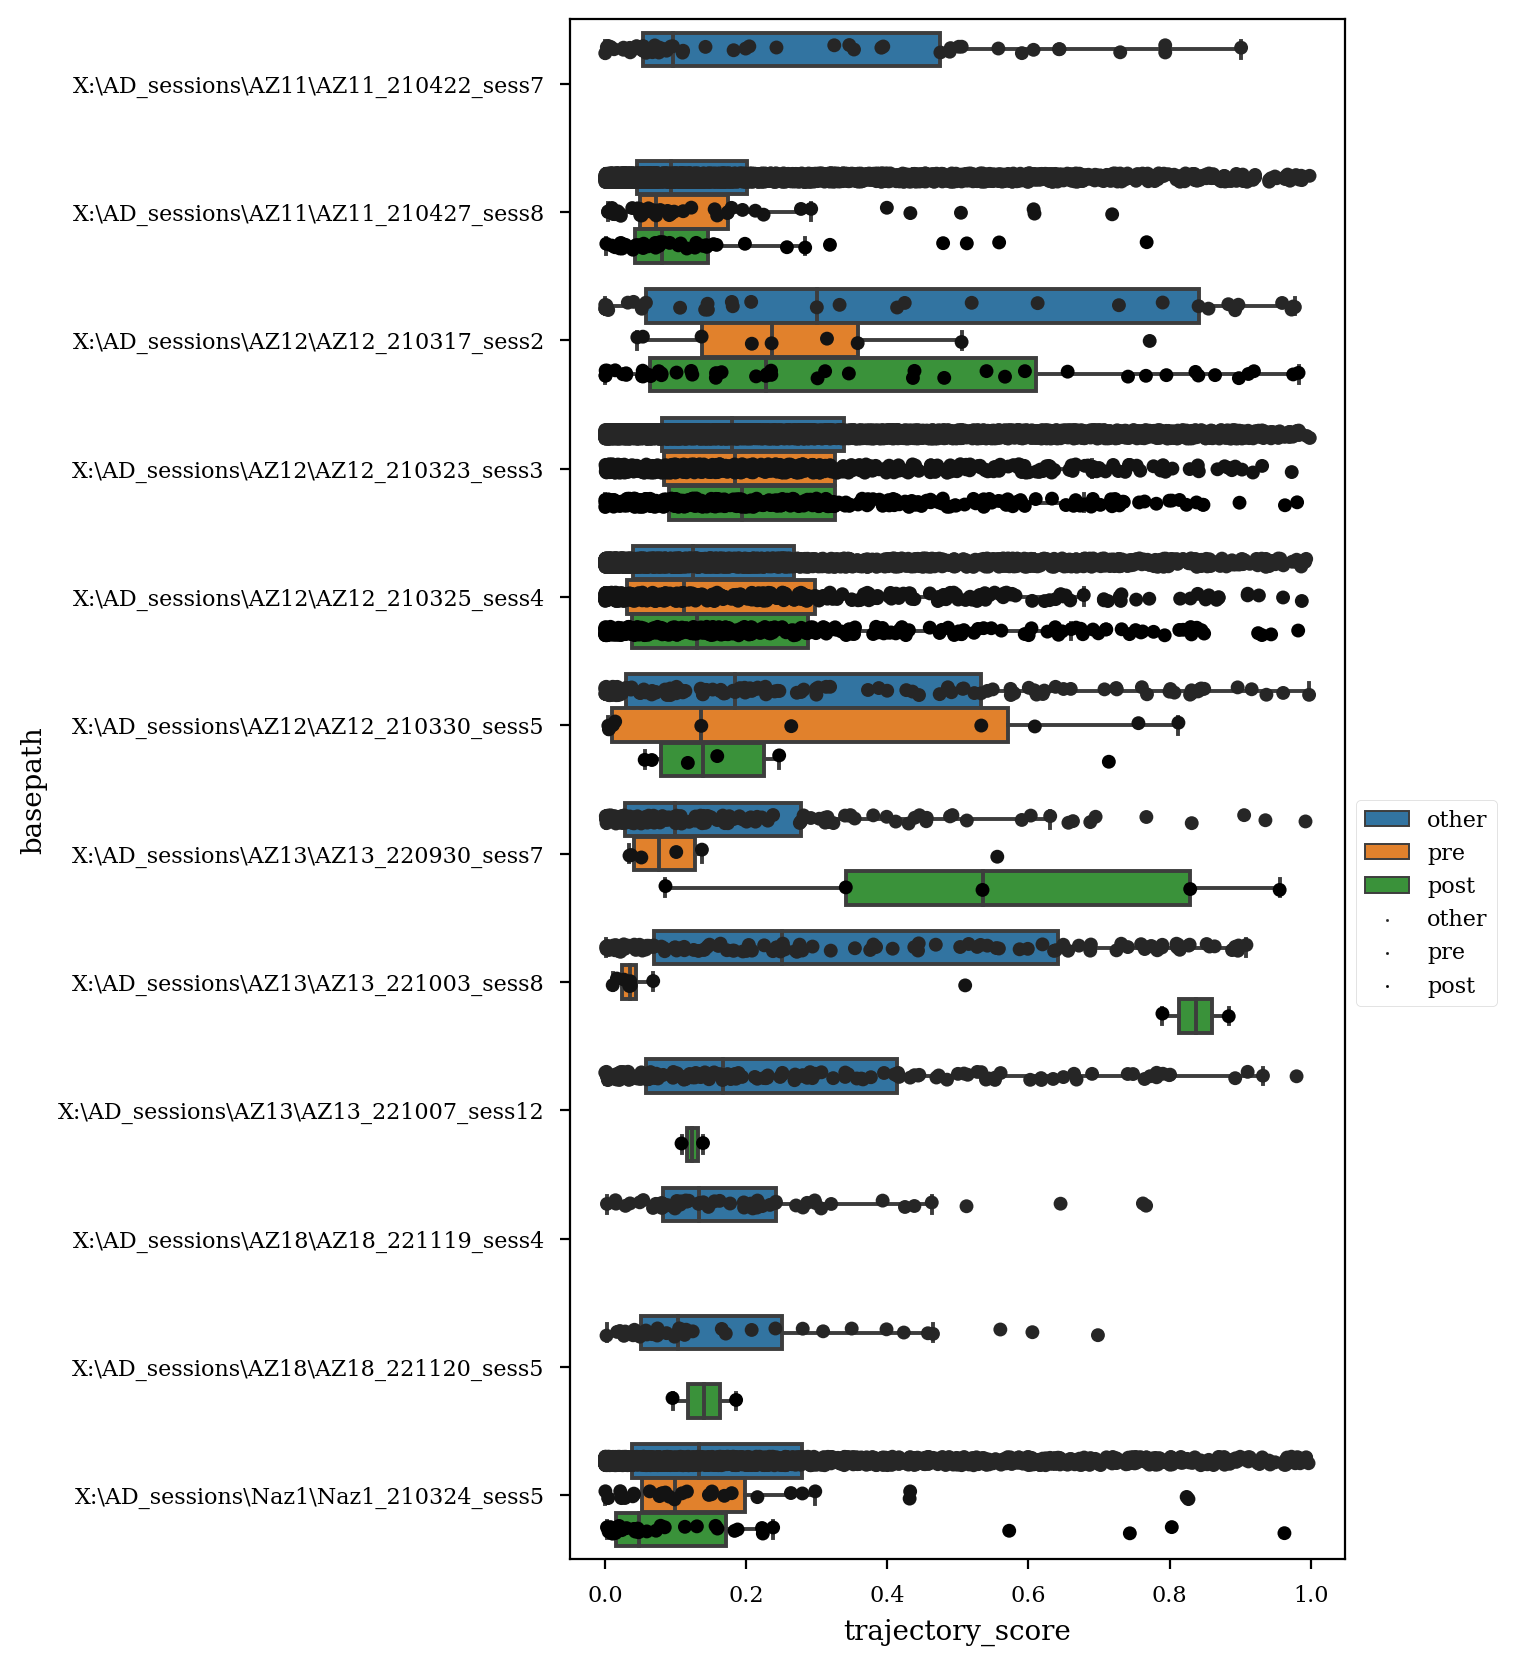

In [25]:
plt.figure(figsize=(5, 10))
sns.boxplot(
    data=results_df.query(query),
    x="trajectory_score",
    y="basepath",
    hue="label",
    showfliers=False,
)
sns.stripplot(
    data=results_df.query(query),
    x="trajectory_score",
    y="basepath",
    hue="label",
    color="k",
    dodge=True,
)
plt.gca().legend(bbox_to_anchor=(1, 0.5), markerscale=0.1)

### z score of shuffle for quality metric

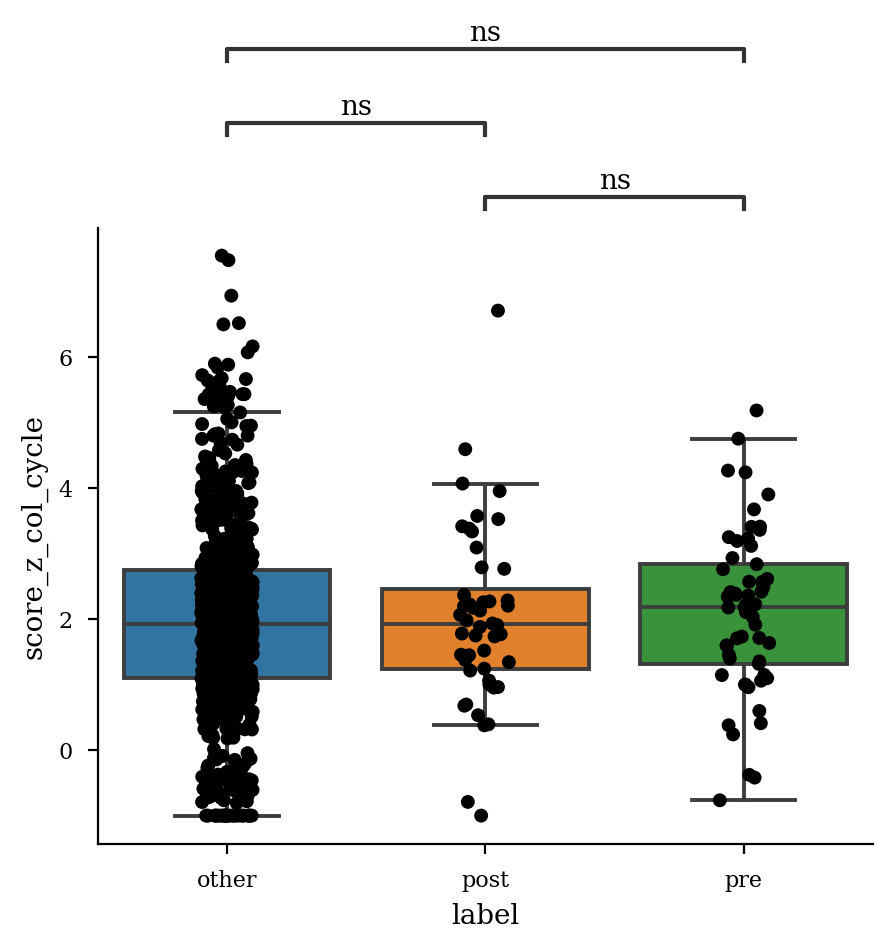

In [26]:
# query = "epoch.str.contains('post') & decoding_median_error < 25 & score_pval_col_cycle < 0.05 & score_pval_time_swap<0.05"
query = "epoch.str.contains('post') & decoding_median_error < 25 & score_pval_time_swap<0.05"

plt.figure(figsize=(5, 4))
sns.boxplot(
    data=results_df.query(query), x="label", y="score_z_col_cycle", showfliers=False
)
sns.stripplot(data=results_df.query(query), x="label", y="score_z_col_cycle", color="k")
annotate_this(results_df.query(query), "label", "score_z_col_cycle", plt.gca())
sns.despine()

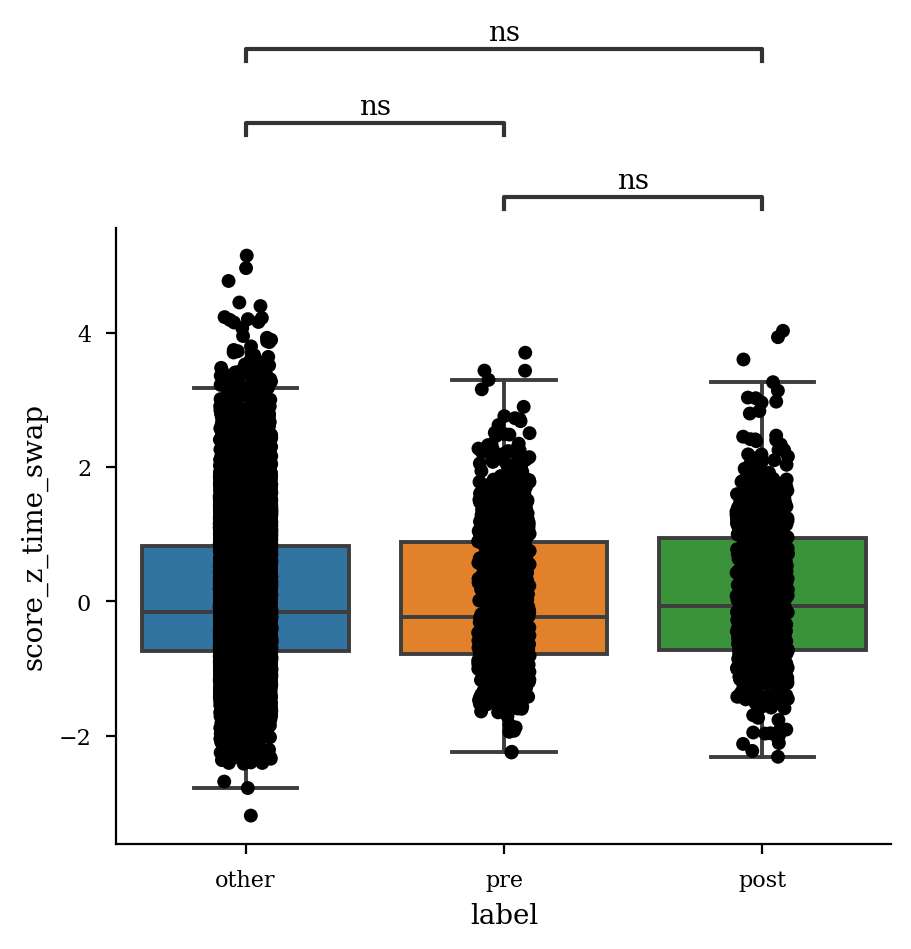

In [27]:
# query = "epoch.str.contains('post') & decoding_median_error < 25 & score_pval_time_swap < 0.05"
# query = "epoch.str.contains('post') & decoding_median_error < 25 & score_pval_col_cycle < 0.05 & score_pval_time_swap<0.05"
query = "epoch.str.contains('post') & decoding_median_error < 25"

plt.figure(figsize=(5, 4))
sns.boxplot(
    data=results_df.query(query), x="label", y="score_z_time_swap", showfliers=False
)
sns.stripplot(data=results_df.query(query), x="label", y="score_z_time_swap", color="k")
annotate_this(results_df.query(query), "label", "score_z_time_swap", plt.gca())
sns.despine()

## Get average trajectory score around IEDs

IED triggered average

In [28]:
def add_ied_epochs(basepath, df):
    current_df = df.query("basepath==@basepath")

    ied_epochs = loading.load_ied_events(basepath)
    if len(ied_epochs) == 0:
        print(f"no IED file {basepath}")
        return pd.DataFrame()

    current_df["event_type"] = "replay_canidate"
    ied_epochs["event_type"] = "IED"
    ied_epochs["basepath"] = basepath

    current_df = pd.concat([current_df, ied_epochs], ignore_index=True)
    current_df = current_df.sort_values(by="start")
    return current_df


replay_ied_df = pd.DataFrame()
for basepath in results_df.basepath.unique():
    current_df = add_ied_epochs(basepath, results_df)
    replay_ied_df = pd.concat([replay_ied_df, current_df], ignore_index=True)

In [32]:
replay_ied_df.keys()

Index(['start', 'stop', 'duration', 'n_active', 'inactive_bin_prop',
       'trajectory_score', 'r_squared', 'slope', 'intercept',
       'score_pval_time_swap', 'score_pval_col_cycle', 'score_z_time_swap',
       'score_z_col_cycle', 'traj_dist', 'traj_speed', 'traj_step',
       'replay_type', 'pop_partic', 'decoding_r2', 'decoding_r2_pval',
       'decoding_median_error', 'total_units', 'direction', 'epoch',
       'basepath', 'age_label', 'label', 'traj_score_presleep_norm',
       'traj_score_pre_post_ied_norm', 'event_type', 'center'],
      dtype='object')

In [41]:
replay_ied_df.epoch.unique()
# replace nan in replay_ied_df.epoch with "unknown"
replay_ied_df["epoch"] = replay_ied_df["epoch"].fillna("unknown")

In [49]:
query = "event_type=='replay_canidate' & epoch.str.contains('post_sleep|tmaze') & score_pval_col_cycle<0.05 & decoding_median_error < 25"

replay_ied_df.query(query).basepath.unique()

array(['X:\\AD_sessions\\AZ11\\AZ11_210422_sess7',
       'X:\\AD_sessions\\AZ11\\AZ11_210427_sess8',
       'X:\\AD_sessions\\AZ12\\AZ12_210317_sess2',
       'X:\\AD_sessions\\AZ12\\AZ12_210323_sess3',
       'X:\\AD_sessions\\AZ12\\AZ12_210325_sess4',
       'X:\\AD_sessions\\AZ12\\AZ12_210330_sess5',
       'X:\\AD_sessions\\AZ13\\AZ13_220930_sess7',
       'X:\\AD_sessions\\AZ13\\AZ13_221003_sess8',
       'X:\\AD_sessions\\AZ13\\AZ13_221007_sess12',
       'X:\\AD_sessions\\AZ18\\AZ18_221119_sess4',
       'X:\\AD_sessions\\AZ18\\AZ18_221120_sess5',
       'X:\\AD_sessions\\Naz1\\Naz1_210324_sess5'], dtype=object)

In [67]:
len(replay_ied_df.query("basepath==@basepath & event_type=='IED'").start.values)

37

In [93]:
replay_peth = pd.DataFrame()
query = "basepath==@basepath & event_type=='replay_canidate' & epoch.str.contains('post_sleep|tmaze') & score_pval_col_cycle<0.05 & decoding_median_error < 25"
# query = "basepath==@basepath & event_type=='replay_canidate' & epoch=='post_sleep' & decoding_median_error < 25"

for basepath in replay_ied_df.basepath.unique():
    ccg = functions.compute_psth(
        [replay_ied_df.query(query).start.values],
        replay_ied_df.query("basepath==@basepath & event_type=='IED'").start.values,
        bin_width=0.8,
        n_bins=50,
    )
    replay_peth = pd.concat(
        [replay_peth, ccg], axis=1, ignore_index=True
    )

replay_peth_zscore = (replay_peth - replay_peth.mean(axis=0)) / replay_peth.std(axis=0)


Text(0, 0.5, 'Replay rate (z-score)')

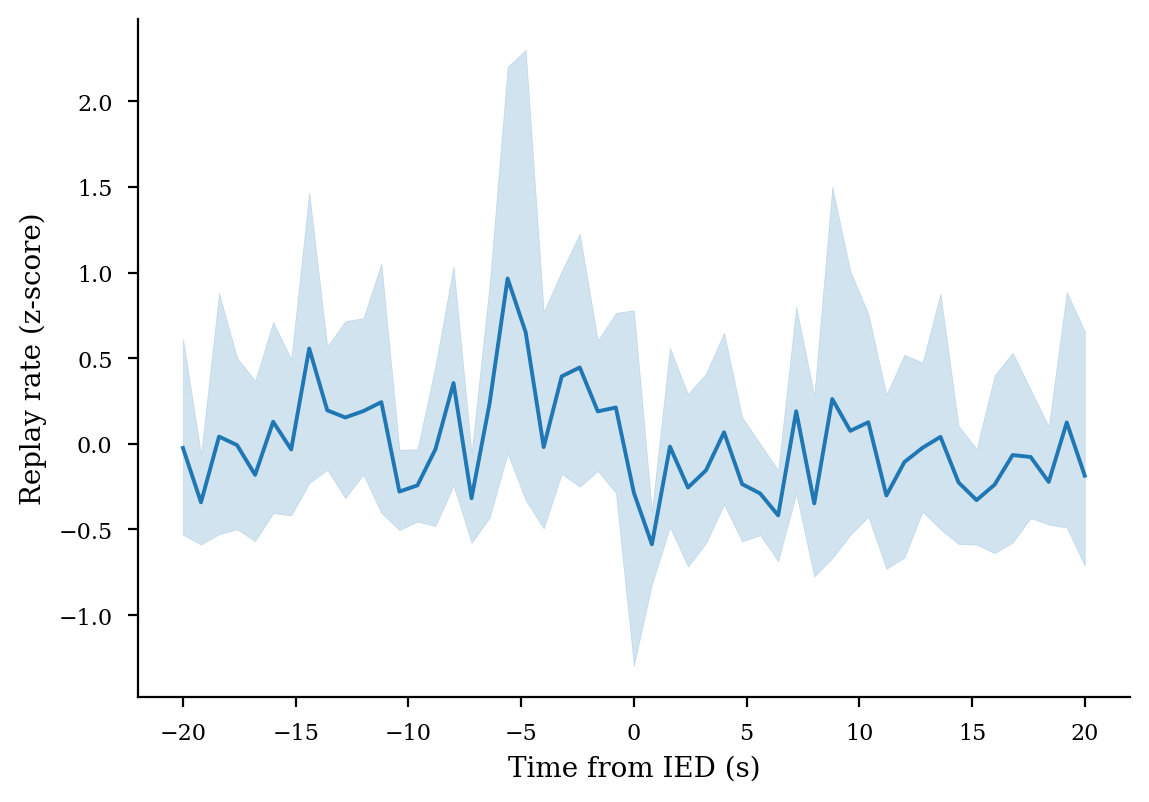

In [94]:
from neuro_py.plotting.events import plot_peth

plot_peth(replay_peth_zscore)
plt.xlabel("Time from IED (s)")
plt.ylabel("Replay rate (z-score)")

In [99]:
average_traj_score = pd.DataFrame()
query = "basepath==@basepath & event_type=='replay_canidate' & epoch.str.contains('post_sleep|tmaze') & decoding_median_error < 25"
# query = "basepath==@basepath & event_type=='replay_canidate' & epoch=='post_sleep' & decoding_median_error < 25"

for basepath in replay_ied_df.basepath.unique():
    average_val, std_val = functions.event_triggered_average_irregular_sample(
        replay_ied_df.query(query).start.values,
        replay_ied_df.query(query).trajectory_score.values,
        replay_ied_df.query("basepath==@basepath & event_type=='IED'").start.values,
        bin_width=1,
        window=[-30, 30],
    )
    average_traj_score = pd.concat(
        [average_traj_score, average_val], axis=1, ignore_index=True
    )

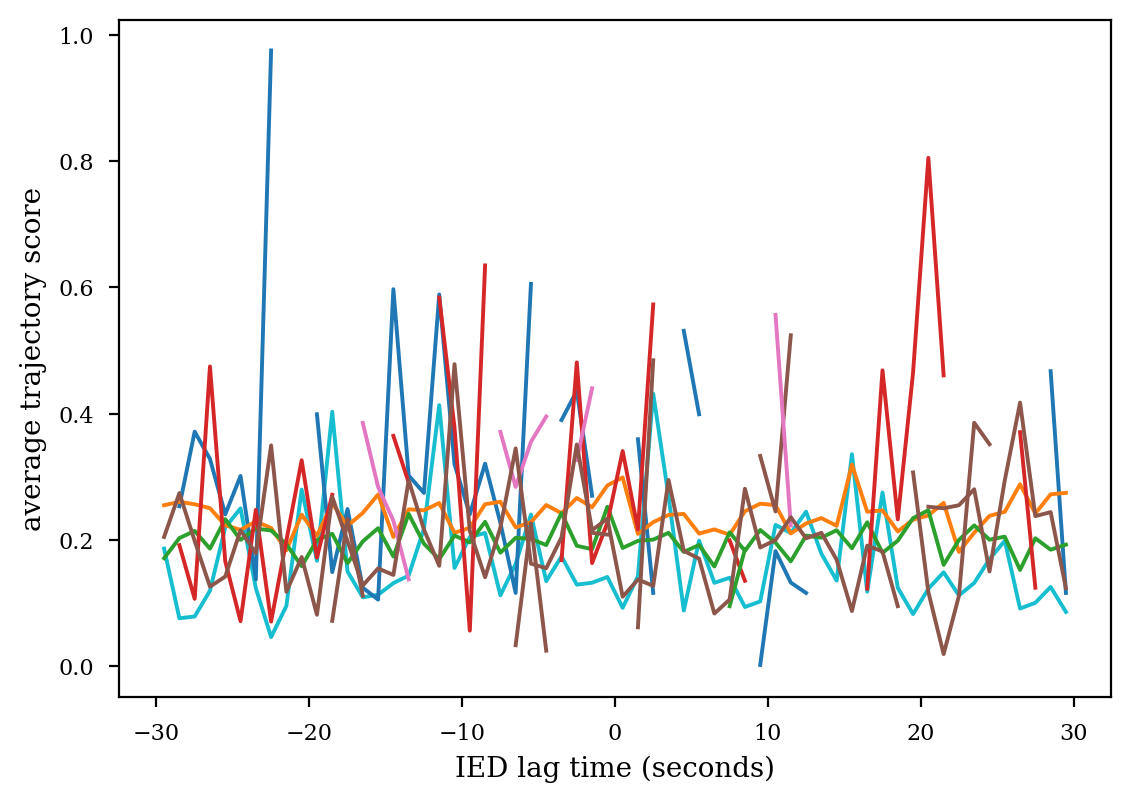

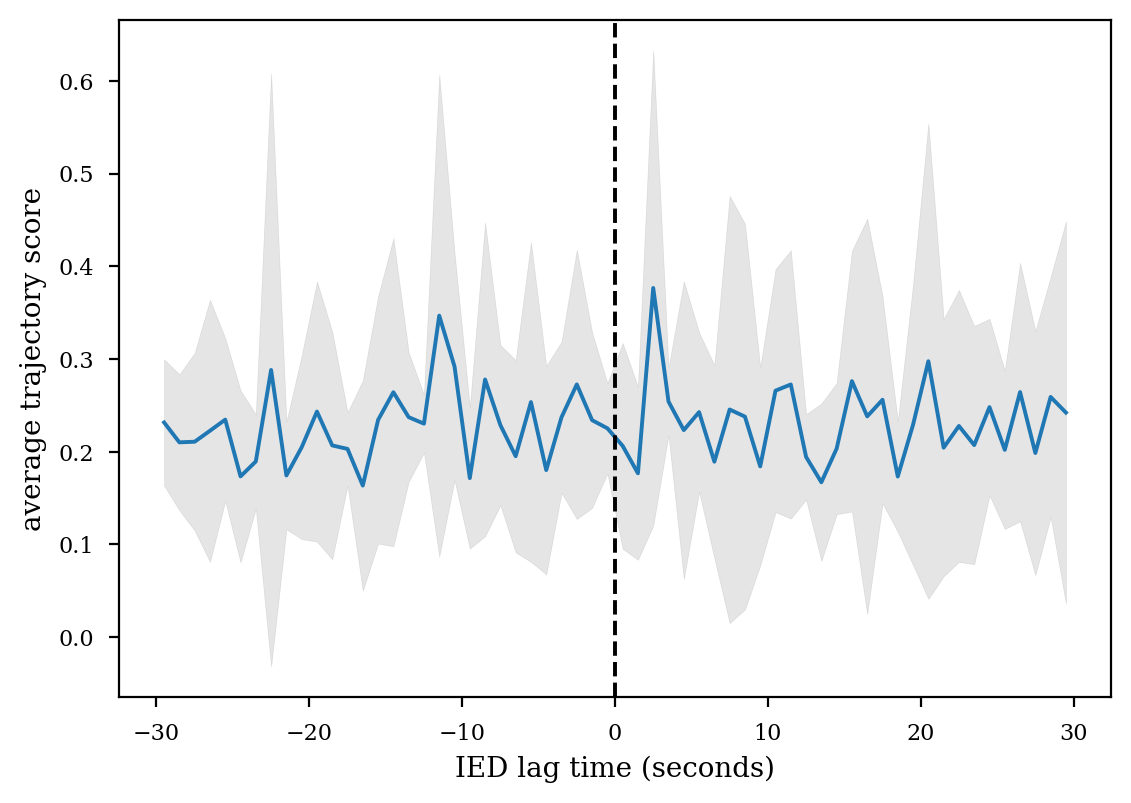

In [100]:
average_traj_score.plot(legend=False)
plt.ylabel("average trajectory score")
plt.xlabel("IED lag time (seconds)")
plt.show()

average_traj_score.mean(axis=1).plot()
plt.fill_between(
    average_traj_score.index,
    (average_traj_score.mean(axis=1).values - average_traj_score.std(axis=1).values),
    (average_traj_score.mean(axis=1).values + average_traj_score.std(axis=1).values),
    color="grey",
    alpha=0.2,
)
plt.ylabel("average trajectory score")
plt.xlabel("IED lag time (seconds)")
plt.axvline(0, color="k", linestyle="--")

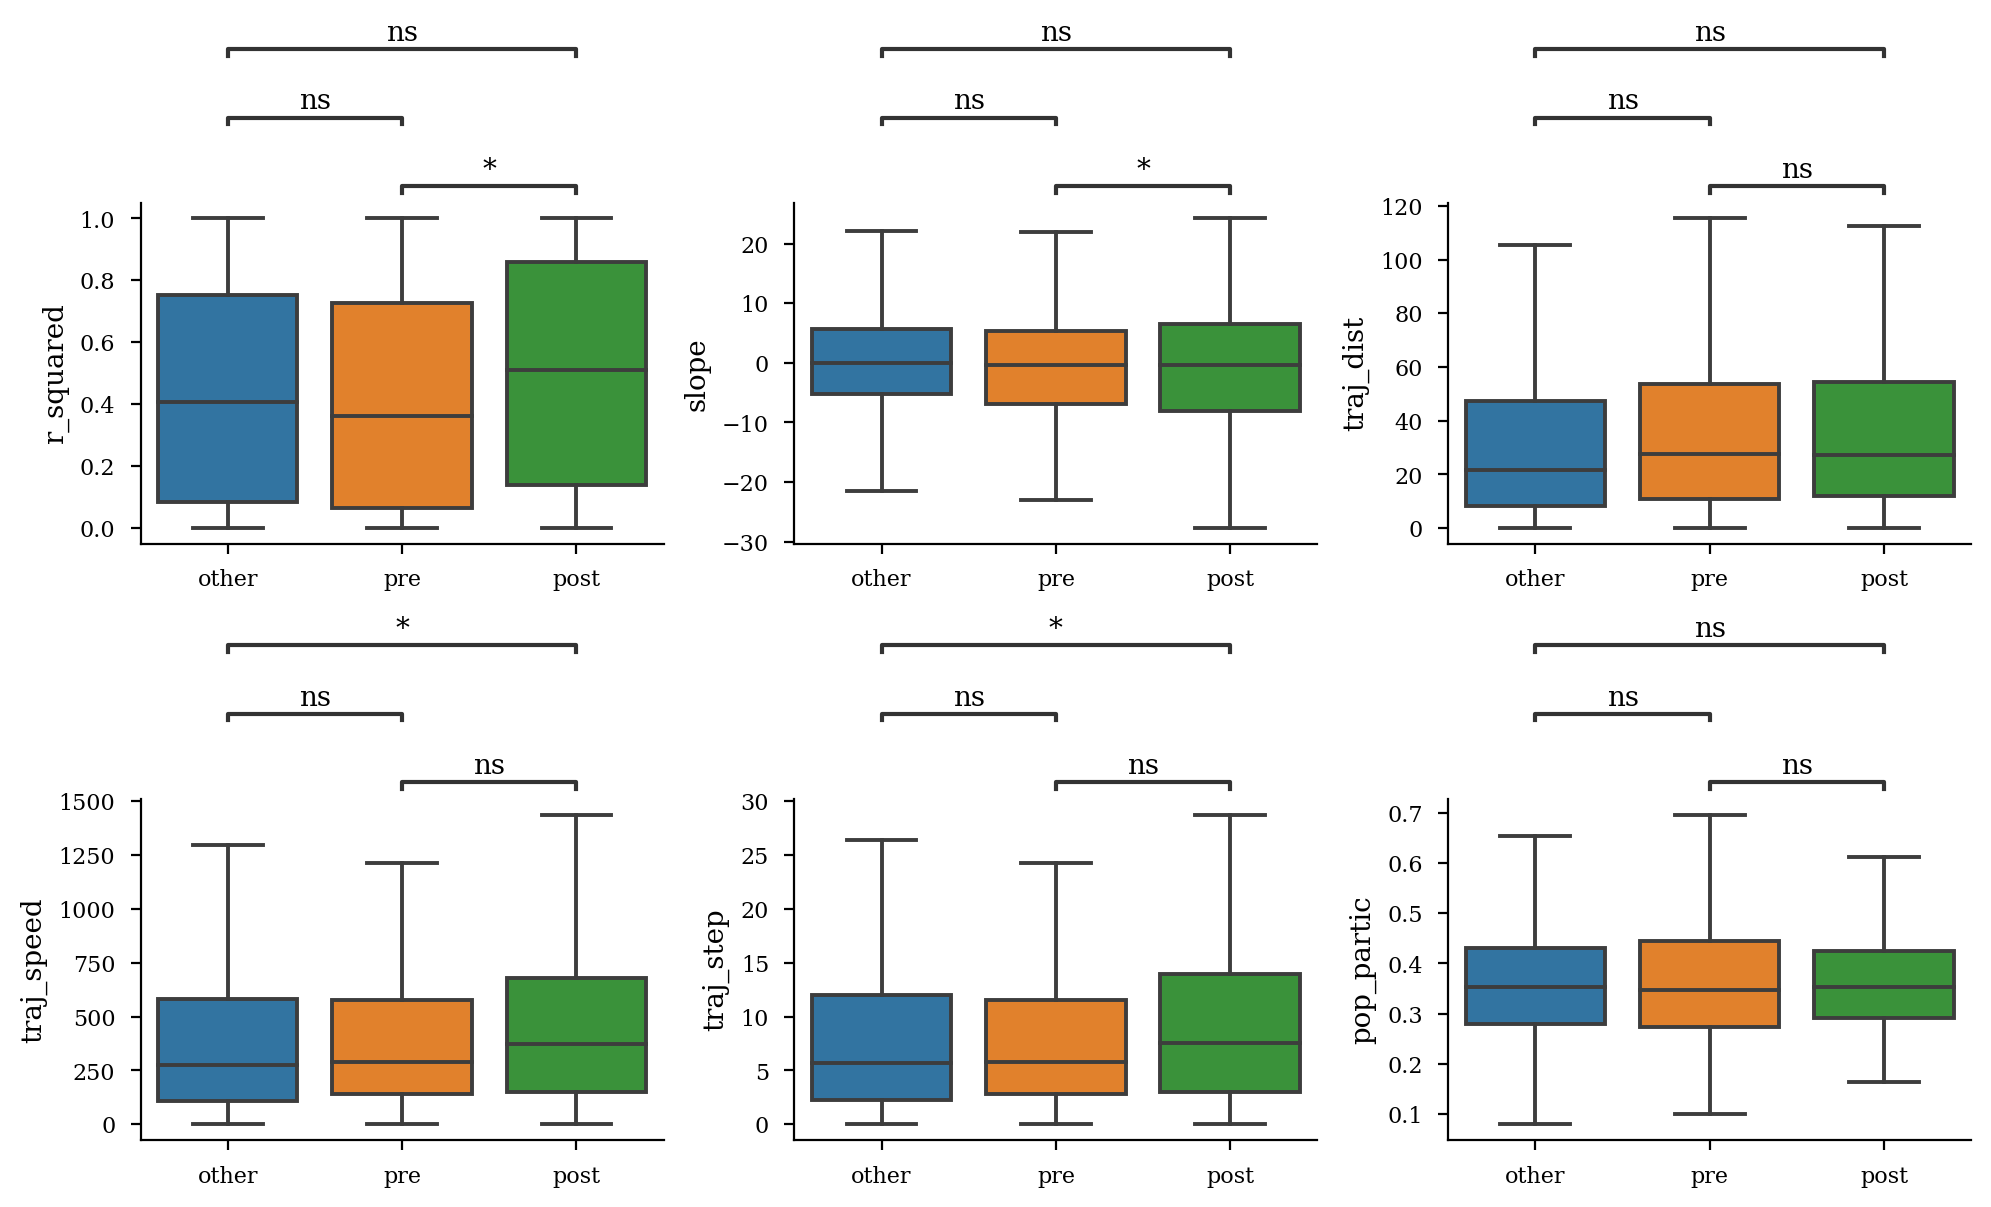

In [98]:
query = "epoch.str.contains('post') & decoding_median_error < 25 & score_pval_col_cycle < 0.05"

fig, ax = plt.subplots(
    2,
    3,
    figsize=functions.set_size("thesis", fraction=2, subplots=(2.5, 3)),
    edgecolor=None,
)
fig.subplots_adjust(hspace=0.75, wspace=0.25)
ax = ax.ravel()

sns.boxplot(
    data=results_df.query(query), x="label", y="r_squared", ax=ax[0], showfliers=False
)
# sns.stripplot(data=results_df.query(query),x="label",y="r_squared",color="k",ax=ax[0])
annotate_this(results_df.query(query), "label", "r_squared", ax[0])

sns.boxplot(
    data=results_df.query(query), x="label", y="slope", ax=ax[1], showfliers=False
)
# sns.stripplot(data=results_df.query(query),x="label",y="slope",color="k",ax=ax[1])
annotate_this(results_df.query(query), "label", "r_squared", ax[1])

sns.boxplot(
    data=results_df.query(query), x="label", y="traj_dist", ax=ax[2], showfliers=False
)
# sns.stripplot(data=results_df.query(query),x="label",y="traj_dist",color="k",ax=ax[2])
annotate_this(results_df.query(query), "label", "traj_dist", ax[2])

sns.boxplot(
    data=results_df.query(query), x="label", y="traj_speed", ax=ax[3], showfliers=False
)
# sns.stripplot(data=results_df.query(query),x="label",y="traj_speed",color="k",ax=ax[3])
annotate_this(results_df.query(query), "label", "traj_speed", ax[3])

sns.boxplot(
    data=results_df.query(query), x="label", y="traj_step", ax=ax[4], showfliers=False
)
# sns.stripplot(data=results_df.query(query),x="label",y="traj_step",color="k",ax=ax[4])
annotate_this(results_df.query(query), "label", "traj_speed", ax[4])

sns.boxplot(
    data=results_df.query(query), x="label", y="pop_partic", ax=ax[5], showfliers=False
)
# sns.stripplot(data=results_df.query(query),x="label",y="pop_partic",color="k",ax=ax[5])
annotate_this(results_df.query(query), "label", "pop_partic", ax[5])

for ax_ in ax:
    ax_.set_xlabel("")
sns.despine()

# plt.savefig(r"D:\github\ad_ied\results\other_replay_metrics.pdf",dpi=300,
#     bbox_inches="tight",
# )
plt.show()

## IED replay rate psth

In [128]:
def extract_replay_ied_psth(basepath, df):
    current_df = df.query("basepath==@basepath")

    ied_epochs = loading.load_ied_events(basepath)
    if len(ied_epochs) == 0:
        return pd.DataFrame(), pd.DataFrame()
    query = "epoch.str.contains('post') & decoding_median_error < 25 & score_pval_col_cycle < 0.05"
    psth_replay = functions.compute_psth(
        [current_df.query(query).start.values],
        ied_epochs.start.values,
        bin_width=0.6,
        n_bins=100,
    )
    query = "epoch.str.contains('post') & decoding_median_error < 25"
    psth_replay_canidate = functions.compute_psth(
        [current_df.query(query).start.values],
        ied_epochs.start.values,
        bin_width=0.6,
        n_bins=100,
    )

    return psth_replay, psth_replay_canidate


psth_replay = pd.DataFrame()
psth_replay_canidate = pd.DataFrame()

for basepath in df.basepath.unique():
    psth_replay_, psth_replay_canidate_ = extract_replay_ied_psth(basepath, df)

    psth_replay = pd.concat([psth_replay, psth_replay_], axis=1, ignore_index=True)
    psth_replay_canidate = pd.concat(
        [psth_replay_canidate, psth_replay_canidate_], axis=1, ignore_index=True
    )

In [129]:
psth_replay_zscore = psth_replay.copy()
psth_replay_zscore[:] = (
    psth_replay.values - np.nanmean(psth_replay.values, axis=0)
) / np.std(psth_replay.values, axis=0)

psth_replay_canidate_zscore = psth_replay_canidate.copy()
psth_replay_canidate_zscore[:] = (
    psth_replay_canidate.values - np.nanmean(psth_replay_canidate.values, axis=0)
) / np.std(psth_replay_canidate.values, axis=0)

<AxesSubplot: >

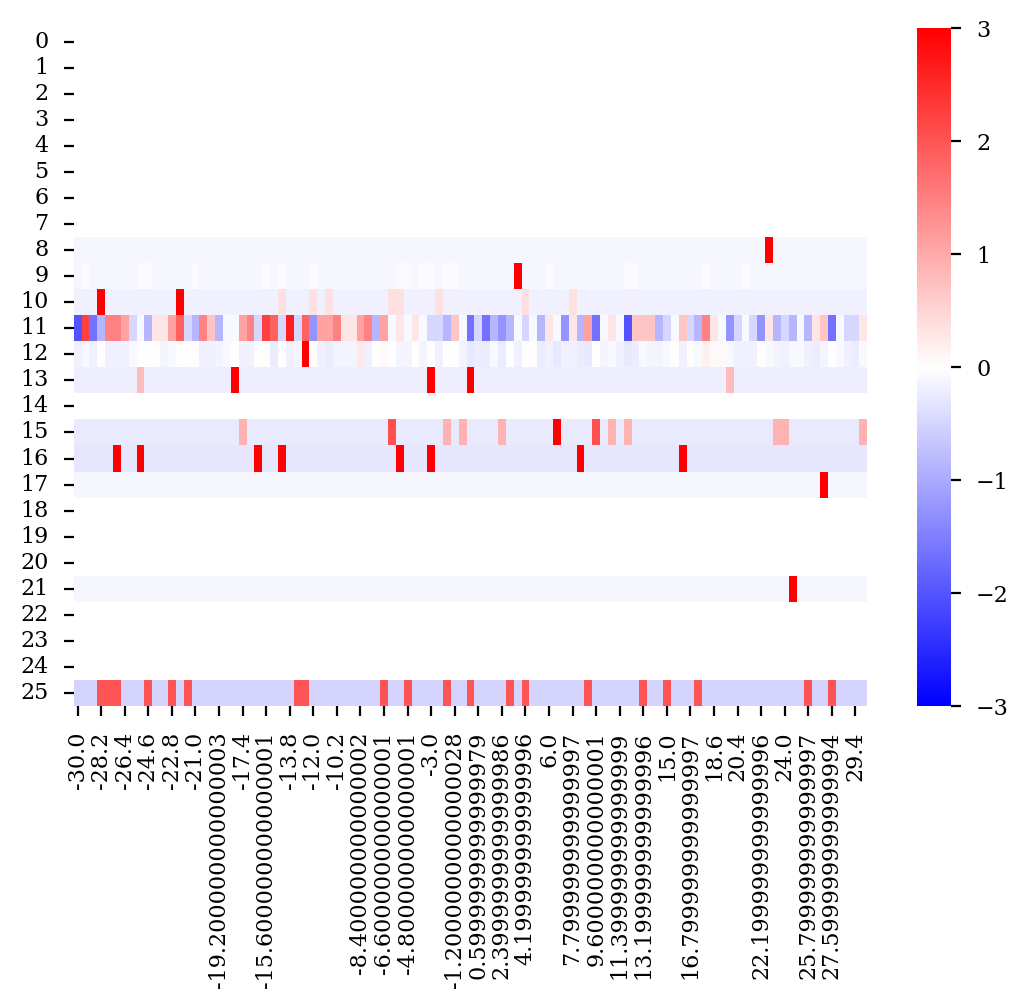

In [170]:
sns.heatmap(psth_replay_zscore.T, vmin=-3, vmax=3, cmap="bwr")

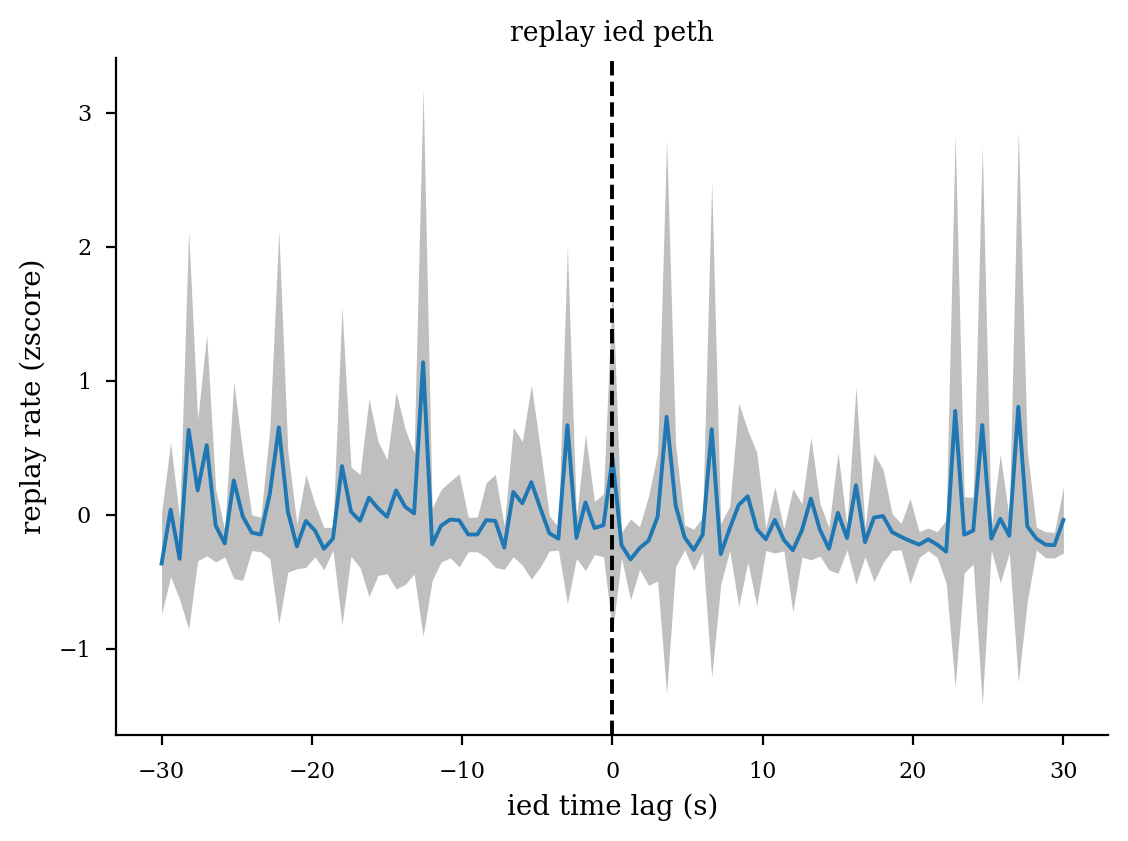

In [153]:
def confidence_intervals(X, conf=0.95):
    # remove nans
    X = X[np.sum(np.isnan(X), axis=1) == 0, :]
    # compute interval for each column
    interval = [
        stats.t.interval(conf, len(a) - 1, loc=np.mean(a), scale=stats.sem(a))
        for a in X.T
    ]
    interval = np.vstack(interval)
    lower = interval[:, 0]
    upper = interval[:, 1]
    return lower, upper


lower, upper = confidence_intervals(psth_replay_zscore.values.T)
psth_replay_zscore.mean(axis=1).plot()

plt.fill_between(
    psth_replay_zscore.index,
    lower,
    upper,
    color="gray",
    alpha=0.5,
    linewidth=0,
)

plt.xlabel("ied time lag (s)")
plt.ylabel("replay rate (zscore)")
plt.title("replay ied peth")
plt.axvline(0, color="k", linestyle="--")
sns.despine()
# plt.savefig(r"D:\github\ad_ied\results\avg_replay_ied_peth.pdf",dpi=300,
#     bbox_inches="tight",
# )

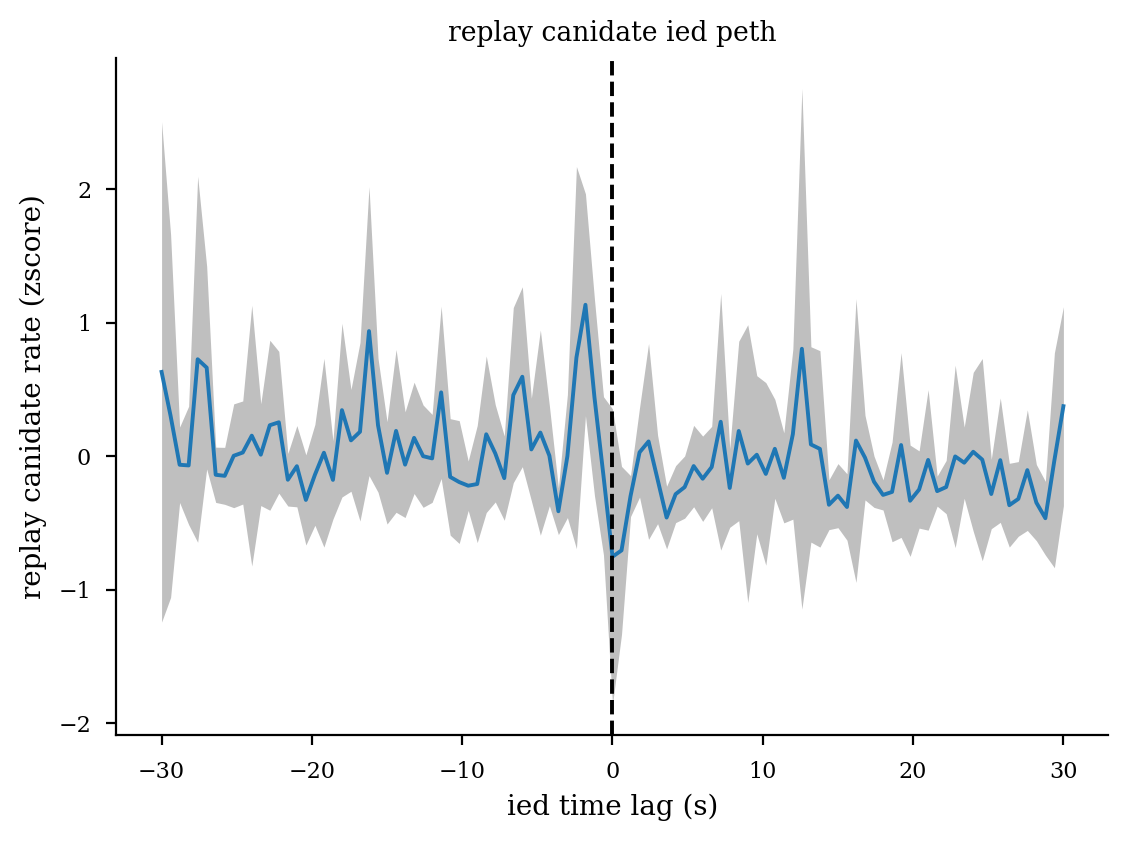

In [152]:
lower, upper = confidence_intervals(psth_replay_canidate_zscore.values.T)
psth_replay_canidate_zscore.mean(axis=1).plot()

plt.fill_between(
    psth_replay_canidate_zscore.index,
    lower,
    upper,
    color="gray",
    alpha=0.5,
    linewidth=0,
)

plt.xlabel("ied time lag (s)")
plt.ylabel("replay canidate rate (zscore)")
plt.title("replay canidate ied peth")
plt.axvline(0, color="k", linestyle="--")
sns.despine()

### testing below

In [3]:
# basepath = r"X:\AD_sessions\AD_10_sess25\Naz1_210324_sess5"
basepath = r"X:\AD_sessions\AZ12_210323_sess3"
ied_epochs = loading.load_ied_events(basepath)
ied_epochs


,start,stop,center
0,2408.8032,2408.8752,2408.8392
1,2439.7336,2439.7888,2439.7592
2,2440.1552,2440.2568,2440.2024
3,2443.2608,2443.3240,2443.2880
4,2445.1768,2445.2488,2445.2144
...,...,...,...
151,22235.8976,22235.9520,22235.9216
152,22267.4152,22267.4720,22267.4408
153,22317.4920,22317.5480,22317.5176
154,22321.9656,22322.0248,22321.9920


In [11]:
current_df.epoch.str.contains("post")


15783    False
15808    False
15820    False
15828    False
15829    False
         ...  
27559     True
27569     True
27587     True
27589     True
27591     True
Name: epoch, Length: 1799, dtype: bool

In [12]:
current_df = df.query("basepath == @basepath & epoch.str.contains('post')")


In [31]:
current_df.shape


(1799, 23)

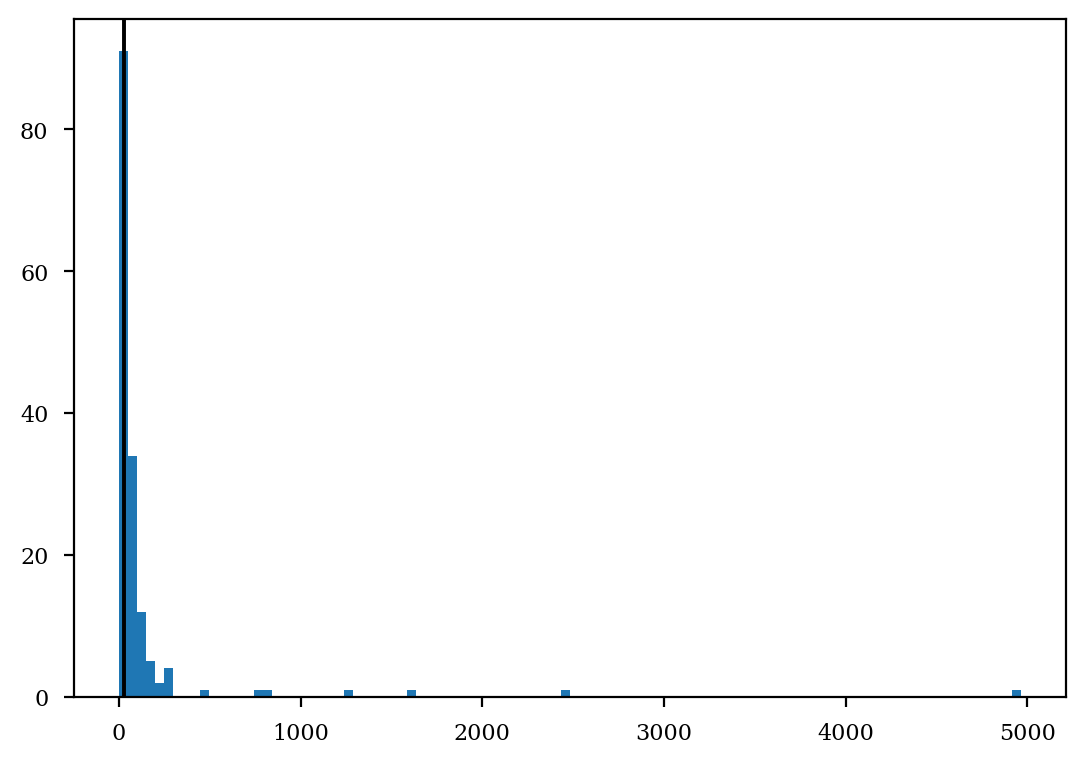

In [60]:
plt.hist(np.diff(ied_epochs.start), 100)
plt.axvline(30, color="k")
plt.show()

In [88]:
# ied_epochs.start


In [5]:
from nelpy.plotting import epochplot


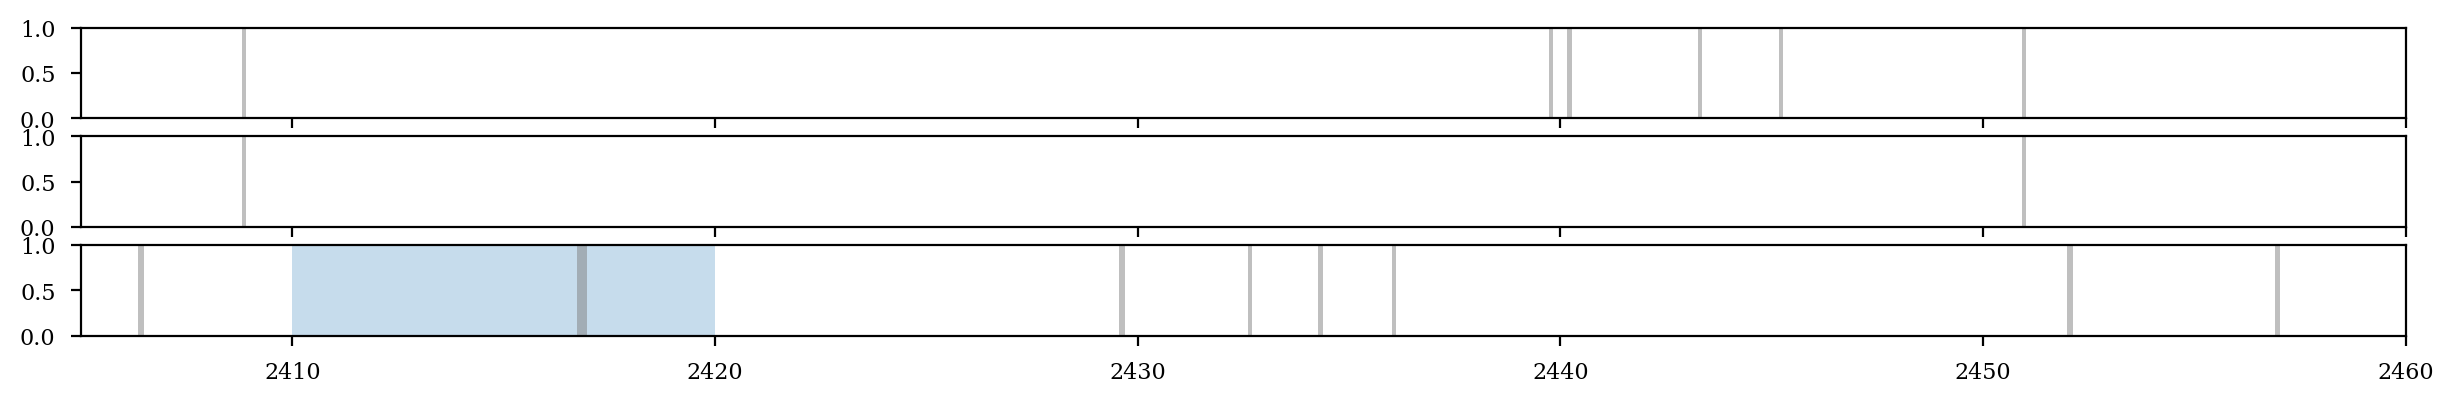

In [85]:
ied_epochs_temp = ied_epochs.loc[np.where(np.diff(ied_epochs.center) > 30)]
ied = nel.EpochArray(np.array([ied_epochs_temp.start, ied_epochs_temp.stop]).T)
ied_obs = nel.EpochArray(np.array([ied_epochs.start, ied_epochs.stop]).T)

replay = nel.EpochArray(np.array([current_df.start, current_df.stop]).T)

fig, ax = plt.subplots(3, 1, figsize=(15, 2), sharex=True)
epochplot(ied_obs, ax=ax[0])
epochplot(ied, ax=ax[1])
epochplot(replay, ax=ax[2])
plt.xlim(2405, 2460)
plt.axvspan(2410, 2420, alpha=0.25, zorder=-1000)

In [175]:
def classify_events(events_1, events_2, interval_pre=[-20, -10], interval_post=[0, 10]):
    """
    Classifies events from events_1 as 'post', 'pre', or 'other'
    based on their relation to events in events_2. An event is
    classified as 'post' if it occurs 0 to 10 seconds after an event
    in events_2, 'pre' if it occurs -20 to -10 seconds before an event
    in events_2, and 'other' if it does not meet either of these criteria.

    Parameters:
      events_1 (list): A list of events.
      events_2 (list): A list of events.

    Returns:
      list: A list of strings with the same length as events_1.
      Each string indicates whether the corresponding event in events_1
      occurred 'post', 'pre', or 'other' relative to an event in events_2.
    """
    # Initialize a list to store the results
    classifications = []

    # Iterate through the events in events_1
    for event_1 in events_1:
        # Initialize a flag to track whether the event has been classified
        classified = False
        # Iterate through the events in events_2
        for event_2 in events_2:
            evt_diff = event_1 - event_2
            # Check if event_1 occurs 0 to 10 seconds after event_2
            if (
                evt_diff > interval_post[0]
                and evt_diff <= interval_post[1]
                and not (evt_diff < interval_pre[1] and evt_diff >= interval_pre[0])
            ):
                # If the event occurs 0 to 10 seconds after event_2, classify it as 'post' and set the flag to True
                classifications.append("post")
                classified = True
                break
            # Check if event_1 occurs -20 to -10 seconds before event_2
            elif (
                evt_diff < interval_pre[1]
                and evt_diff >= interval_pre[0]
                and not (evt_diff > interval_post[0] and evt_diff <= interval_post[1])
            ):
                # If the event occurs -20 to -10 seconds before event_2, classify it as 'pre' and set the flag to True
                classifications.append("pre")
                classified = True
                break
        # If the event has not been classified, classify it as 'other'
        if not classified:
            classifications.append("other")

    # Return the list of classifications
    return classifications


label = classify_events(current_df.start.values, ied_epochs.start)
current_df["label"] = label

len(label)

1799

<AxesSubplot: xlabel='label', ylabel='trajectory_score'>

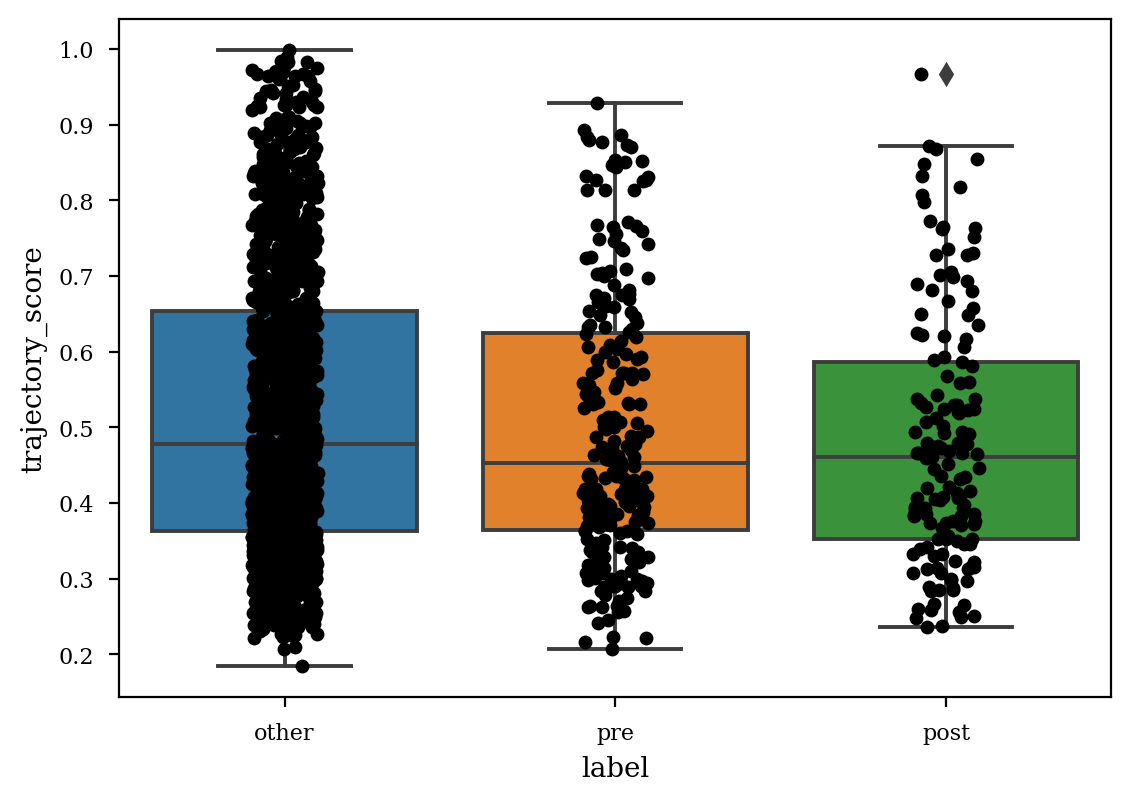

In [266]:
# current_df.query("label.str.contains('pre')")
sns.boxplot(data=current_df, x="label", y="trajectory_score")
sns.stripplot(data=current_df, x="label", y="trajectory_score", color="k")

In [141]:
# label = []
# for replay_start in current_df.start.values:
#     time_diff = replay_start - ied_epochs.start.values
#     time_diff_post = time_diff[time_diff > 0]
#     if len(time_diff_post) == 0:
#         time_diff_post = np.nan
#     if (np.min(time_diff_post) < 10) and (np.min(time_diff_post) > 0) and not ((time_diff.max() > -20) and (time_diff.max() < -10)):
#         label.append("post")
#     elif (time_diff.max() > -20) and (time_diff.max() < -10) and not ((np.min(time_diff_post) < 10) and (np.min(time_diff_post) > 0)):
#         label.append("pre")
#     else:
#         label.append("other")
# current_df["label"] = label

# current_df.query("label.str.contains('pre_ied|post_ied')")


<AxesSubplot: >

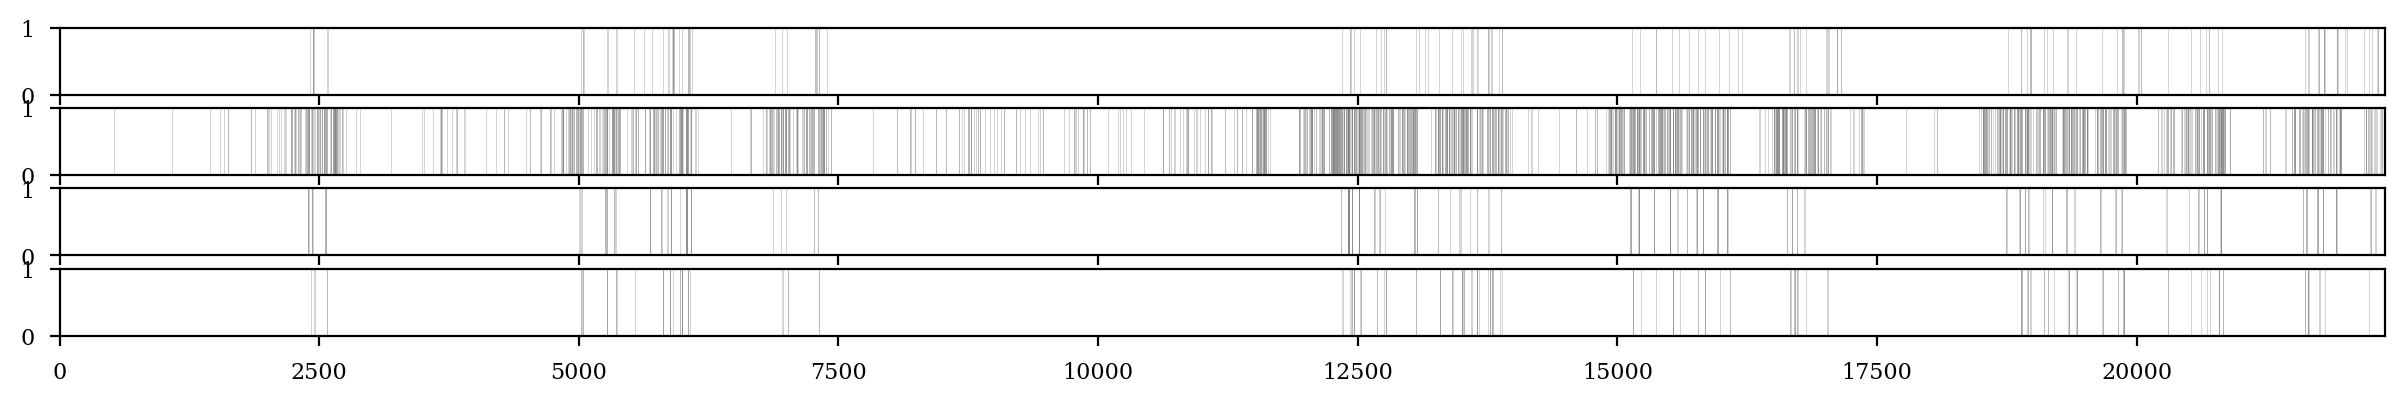

In [170]:
ied_obs = nel.EpochArray(np.array([ied_epochs.start, ied_epochs.stop]).T)
replay = nel.EpochArray(np.array([current_df.start, current_df.stop]).T)
replay_pre = nel.EpochArray(
    np.array(
        [
            current_df.query("label.str.contains('pre')").start,
            current_df.query("label.str.contains('pre')").stop,
        ]
    ).T
)
replay_post = nel.EpochArray(
    np.array(
        [
            current_df.query("label.str.contains('post')").start,
            current_df.query("label.str.contains('post')").stop,
        ]
    ).T
)

fig, ax = plt.subplots(4, 1, figsize=(15, 2), sharex=True)
epochplot(ied_obs, ax=ax[0])
epochplot(replay, ax=ax[1])
epochplot(replay_pre, ax=ax[2])
epochplot(replay_post, ax=ax[3])

In [171]:
replay_pre, replay_post

(<EpochArray at 0x26e0a538e80: 240 epochs> of length 23.6 seconds,
 <EpochArray at 0x26e0c557670: 174 epochs> of length 17.44 seconds)

(5970.0, 6000.0)

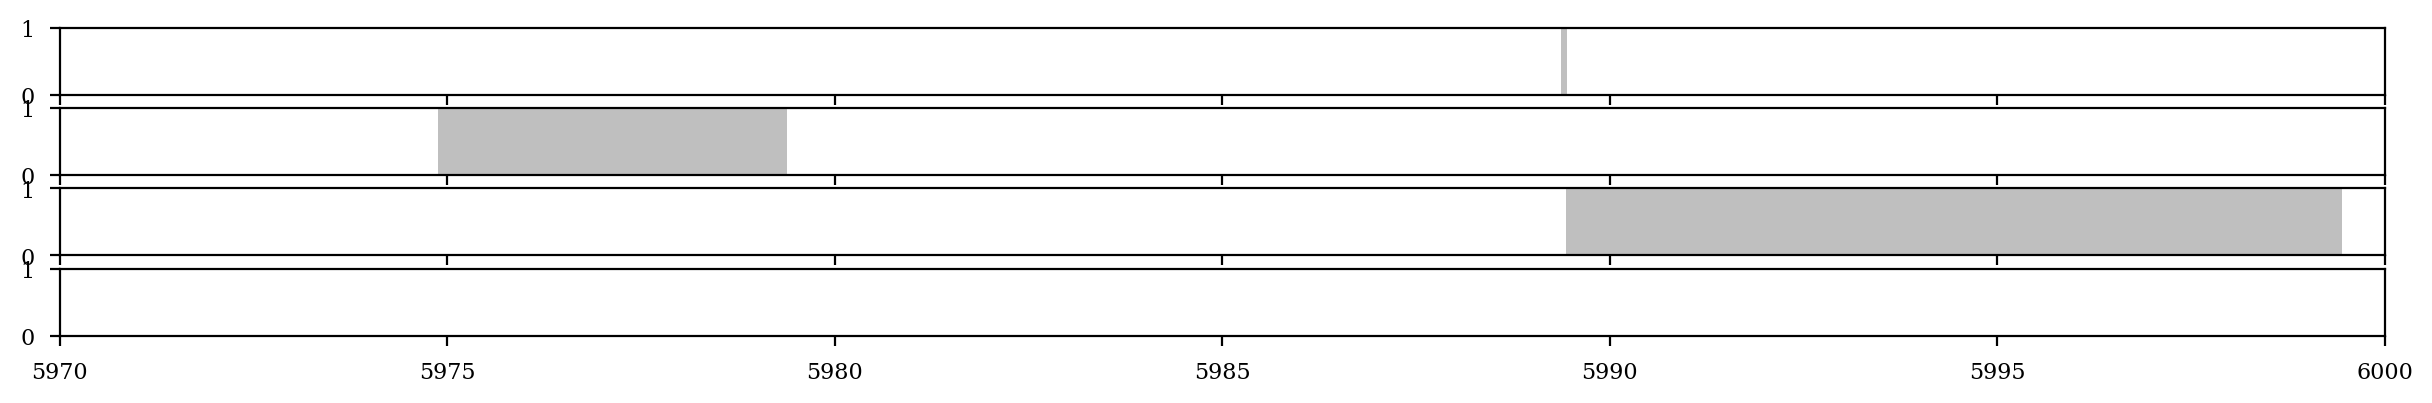

In [13]:
ied_obs = nel.EpochArray(np.array([ied_epochs.start, ied_epochs.stop]).T)

ied_obs_pre_ = nel.EpochArray(
    np.array([ied_epochs.start - 20, ied_epochs.start - 10]).T
)
ied_obs_post_ = nel.EpochArray(np.array([ied_epochs.stop, ied_epochs.stop + 10]).T)

ied_obs_pre = ied_obs_pre_[~ied_obs_post_]

ied_obs_post = ied_obs_post_[~ied_obs_pre_]

fig, ax = plt.subplots(4, 1, figsize=(15, 2), sharex=True)
epochplot(ied_obs, ax=ax[0])
epochplot(ied_obs_pre, ax=ax[1])
epochplot(ied_obs_post, ax=ax[2])
plt.xlim(5970, 6000)

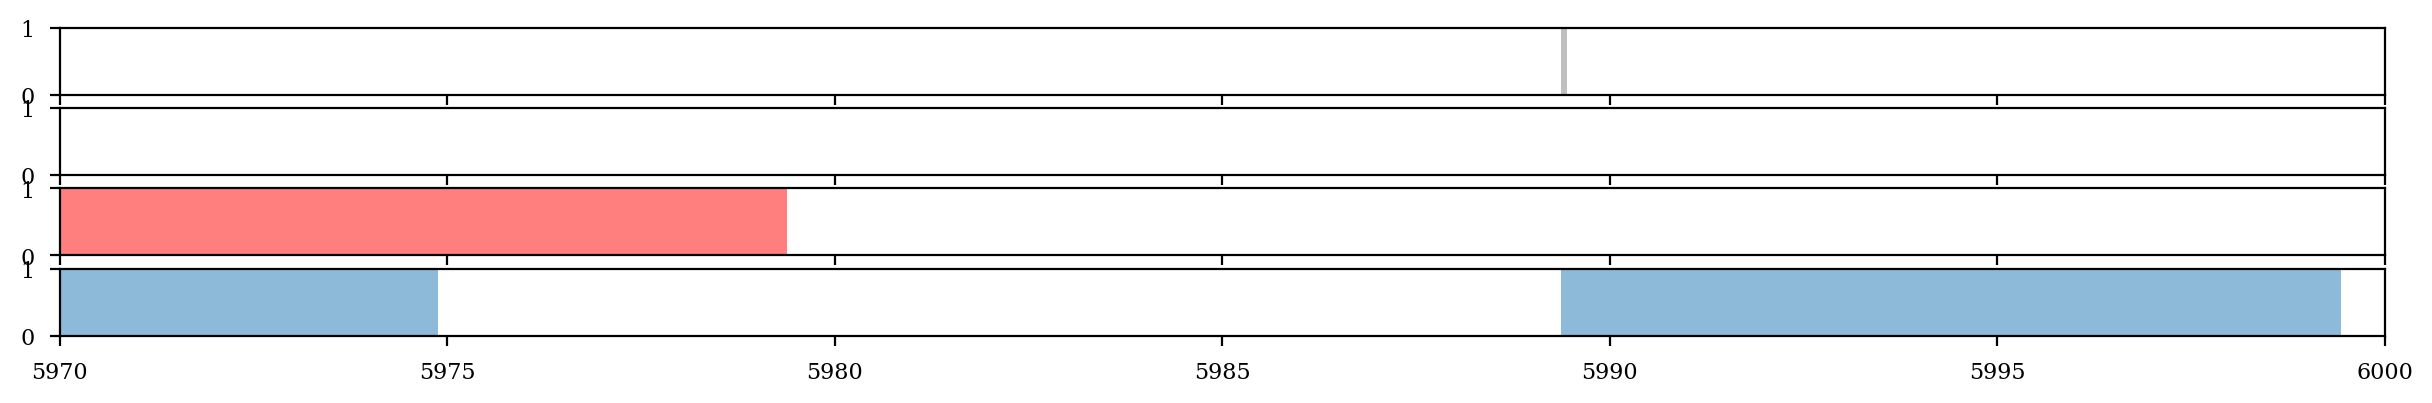

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

post vs. pre: Mann-Whitney-Wilcoxon test two-sided, P_val:9.768e-01 U_stat=1.017e+04


(<AxesSubplot: xlabel='label', ylabel='trajectory_score'>,
 [<statannotations.Annotation.Annotation at 0x26a57df1f10>])

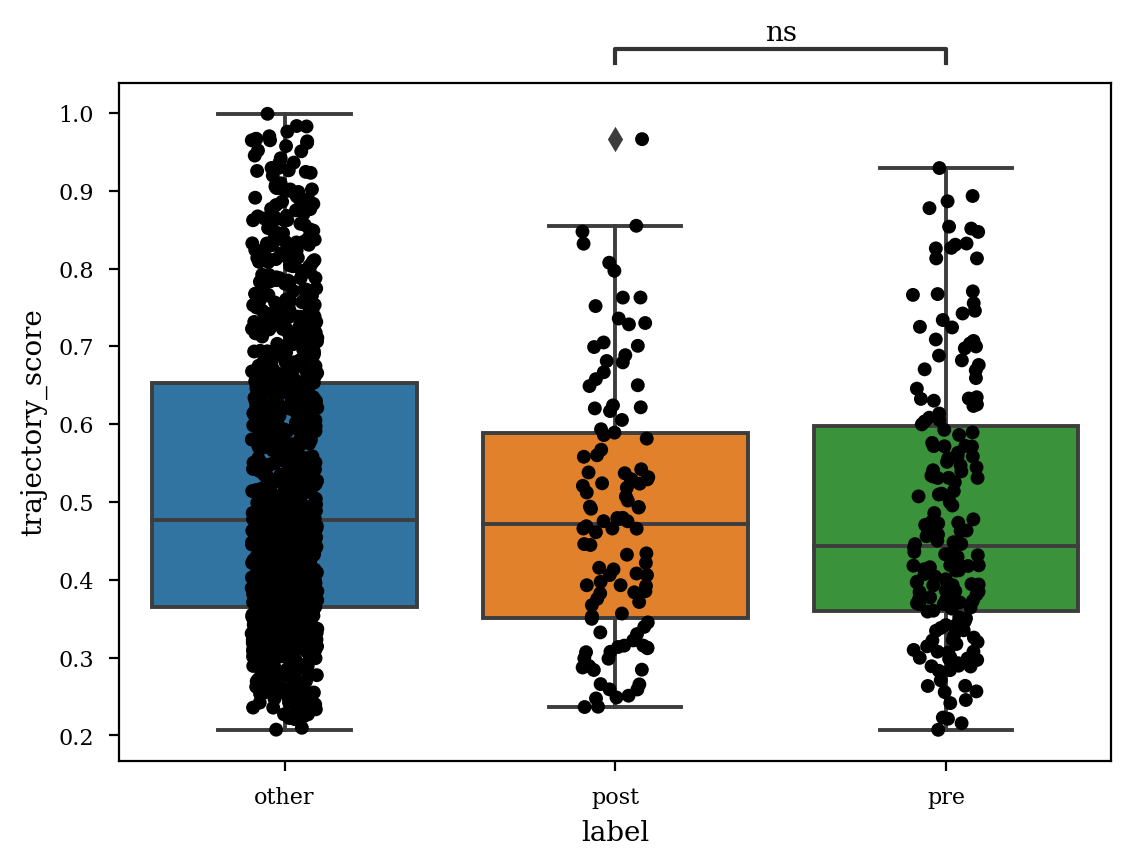

In [14]:
current_df["label"] = "other"
idx = functions.in_intervals(current_df.start.values, ied_obs_pre.data)
# idx = functions.find_intersecting_intervals(replay, replay[ied_obs_pre])
current_df.loc[idx, "label"] = "pre"
# idx = functions.find_intersecting_intervals(replay, replay[ied_obs_post])
idx = functions.in_intervals(current_df.start.values, ied_obs_post.data)
current_df.loc[idx, "label"] = "post"


ied_obs = nel.EpochArray(np.array([ied_epochs.start, ied_epochs.stop]).T)
replay = nel.EpochArray(np.array([current_df.start, current_df.stop]).T)
replay_pre = nel.EpochArray(
    np.array(
        [
            current_df.query("label.str.contains('pre')").start,
            current_df.query("label.str.contains('pre')").stop,
        ]
    ).T
)
replay_post = nel.EpochArray(
    np.array(
        [
            current_df.query("label.str.contains('post')").start,
            current_df.query("label.str.contains('post')").stop,
        ]
    ).T
)

fig, ax = plt.subplots(4, 1, figsize=(15, 2), sharex=True)
epochplot(ied_obs, ax=ax[0])
for ep in ied_obs:
    ax[2].axvspan(ep.start - 20, ep.start - 10, color="r", alpha=0.5, zorder=-1000)
    ax[3].axvspan(ep.start, ep.stop + 10, alpha=0.5, zorder=-1000)
epochplot(replay, ax=ax[1])
epochplot(replay_pre, ax=ax[2])
epochplot(replay_post, ax=ax[3])
plt.xlim(5970, 6000)
plt.show()


from statannotations.Annotator import Annotator

sns.boxplot(data=current_df, x="label", y="trajectory_score")
sns.stripplot(data=current_df, x="label", y="trajectory_score", color="k")

box_pairs = [("pre", "post")]
annotator = Annotator(
    plt.gca(),
    box_pairs,
    data=current_df,
    x="label",
    y="trajectory_score",
)
annotator.configure(
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    comparisons_correction=None,
    verbose=1,
)
annotator.apply_and_annotate()

In [269]:
pip install statannotations

  Using cached statannotations-0.5.0-py3-none-any.whl (31 kB)
  Using cached seaborn-0.11.2-py3-none-any.whl (292 kB)
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.1
    Uninstalling seaborn-0.12.1:
      Successfully uninstalled seaborn-0.12.1
Note: you may need to restart the kernel to use updated packages.


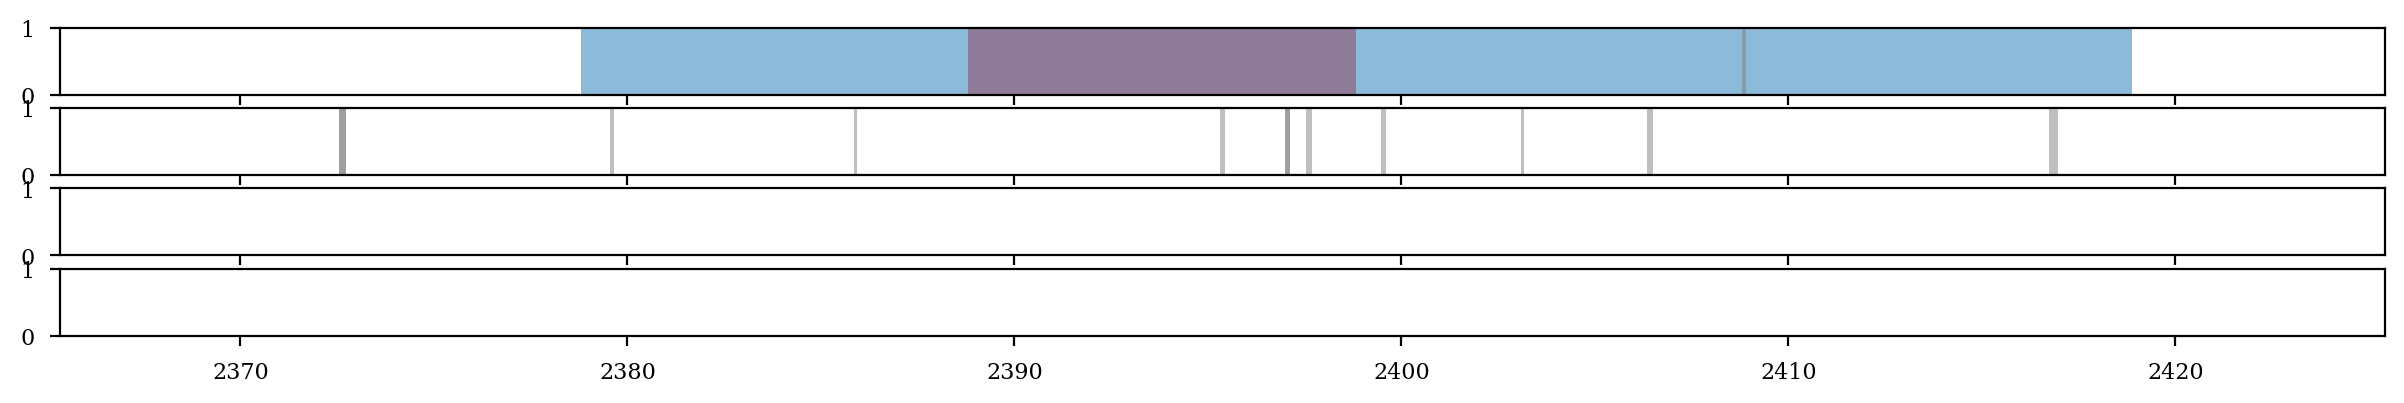

In [233]:
ied_obs = nel.EpochArray(np.array([ied_epochs.start, ied_epochs.stop]).T)
replay = nel.EpochArray(np.array([current_df.start, current_df.stop]).T)
replay_pre = nel.EpochArray(
    np.array(
        [
            current_df.query("label.str.contains('pre')").start,
            current_df.query("label.str.contains('pre')").stop,
        ]
    ).T
)
replay_post = nel.EpochArray(
    np.array(
        [
            current_df.query("label.str.contains('post')").start,
            current_df.query("label.str.contains('post')").stop,
        ]
    ).T
)

fig, ax = plt.subplots(4, 1, figsize=(15, 2), sharex=True)
epochplot(ied_obs, ax=ax[0])
epochplot(replay, ax=ax[1])
epochplot(replay_pre, ax=ax[2])
epochplot(replay_post, ax=ax[3])

plt.xlim(2395.32485 - 30, 2395.40485 + 30)
# plt.axvspan(2395.32485,2395.40485,alpha=.5,zorder=1000)
ax[0].axvspan(
    ied_obs[0].start - 20, ied_obs[0].start - 10, color="r", alpha=0.5, zorder=-1000
)

ax[0].axvspan(ied_obs[0].start - 30, ied_obs[0].stop + 10, alpha=0.5, zorder=-1000)

In [107]:
np.argmin(np.abs(ied_obs.starts - 2410))


0

In [55]:
np.diff(ied_epochs.start) > 30


array([ True, False, False, False, False,  True, False,  True, False,
       False, False,  True, False,  True, False,  True,  True,  True,
        True,  True, False,  True, False, False, False,  True, False,
        True, False, False, False, False, False,  True,  True,  True,
        True, False, False, False,  True,  True,  True, False, False,
       False,  True,  True,  True, False, False, False,  True, False,
        True, False,  True,  True,  True, False,  True, False, False,
        True, False,  True, False, False, False, False,  True, False,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
       False, False, False,  True,  True, False, False, False,  True,
       False, False,  True, False,  True,  True, False,  True, False,
       False, False, False,  True,  True,  True,  True, False,  True,
        True,  True,  True, False,  True, False, False, False,  True,
        True,  True,

In [43]:
time_range = [-20, 10]
time_range = [0, 10]

trajectory_score = []
events = current_df.start.values
for r in ied_epochs.start:
    idx = (events > r + time_range[0]) & (events < r + time_range[1])
    trajectory_score.append(current_df[idx].trajectory_score.values)

In [53]:
np.abs(current_df.start.values[100] - ied_epochs.start).min()


47.24235000000044

In [ ]:
for ripple_start in current_df.start.values:
    ied_epochs.start


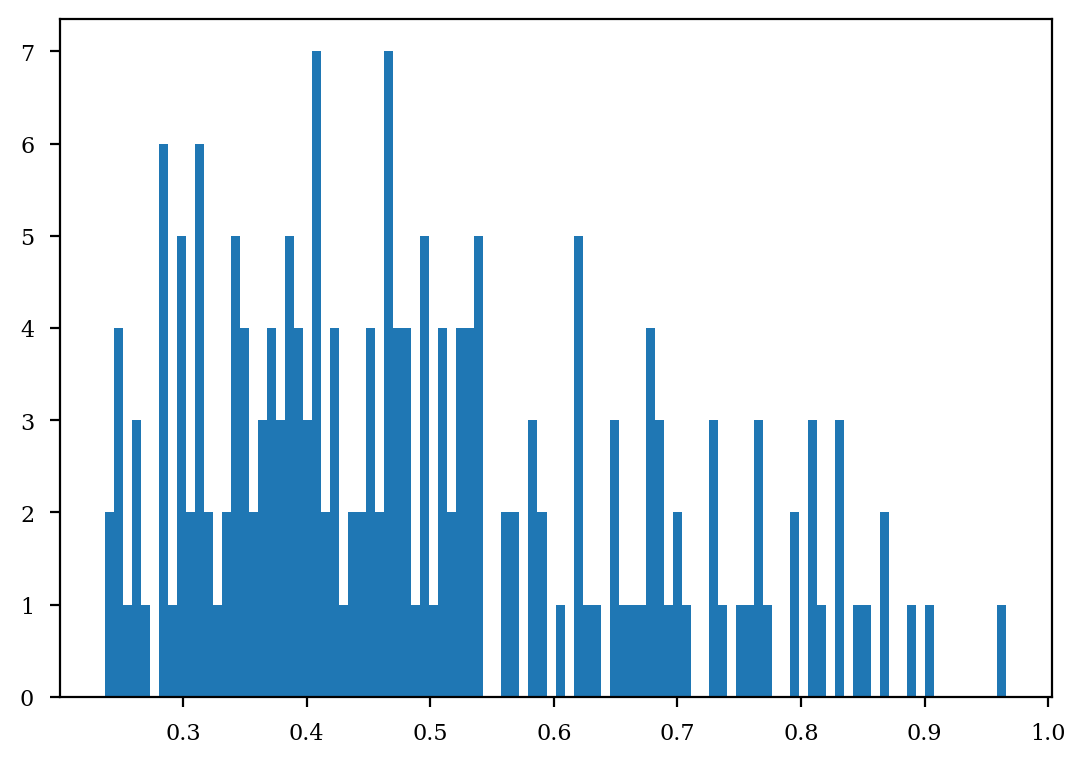

In [44]:
plt.hist(np.hstack(trajectory_score), 100)
plt.show()

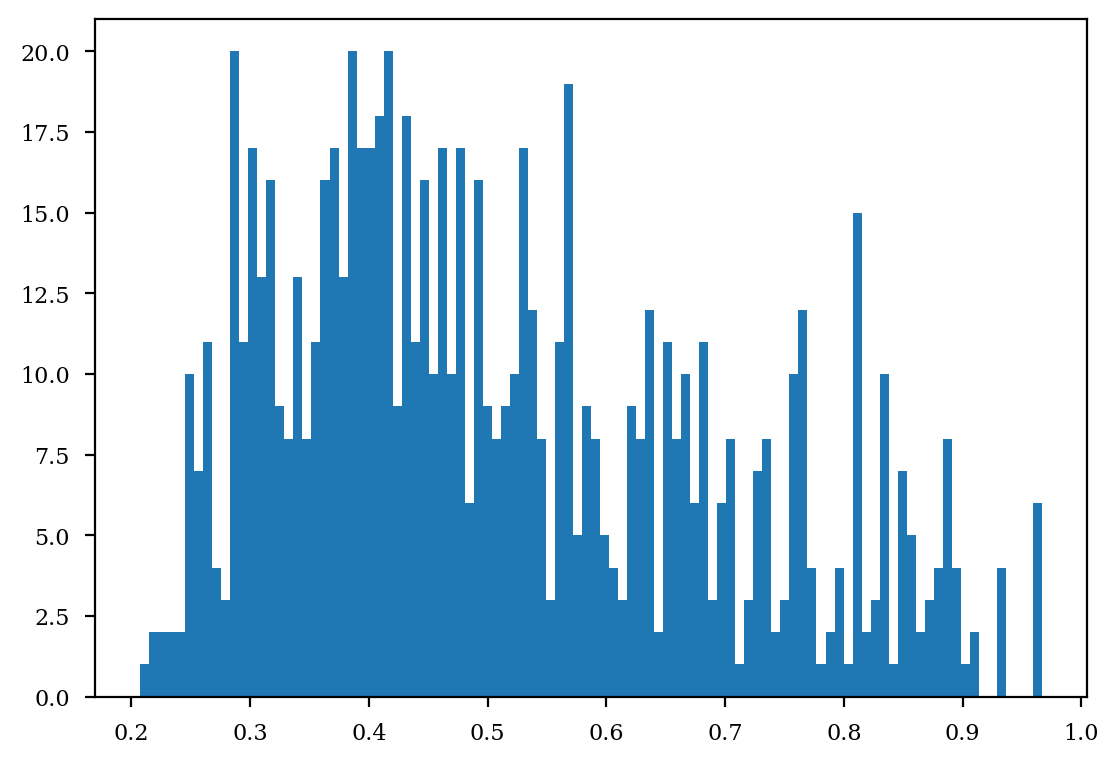

In [42]:
plt.hist(np.hstack(trajectory_score), 100)
plt.show()